# Bachelier 

# General Imports and Settings

In [1]:
# For Google Colab
%pip install jaxtyping
%pip install equinox

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

import pytest
import pytest_benchmark

jax.enable_checks = True

jax.devices()

2023-07-01 14:44:45.684614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-01 14:44:47.249441: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[gpu(id=0)]

In [2]:
# list requirements
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.4.12
equinox==0.10.5
optax==0.1.4
chex==0.1.7
tensorflow==2.12.0
tensorflow_datasets==4.9.2
numpy==1.23.5
pytest==7.3.1
pytest_benchmark==4.0.0


In [3]:
# test: edited with colab
NUM_EPOCHS = 100
# BATCH_SIZE = 256
BATCH_SIZE = 512
BUFFER_SIZE = 1024
# STEPS_PER_EPOCH = 16
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096
SEED = 42

In [4]:
@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

In [5]:
def sigmoidal_smoothing(f, k=10):

    def smooth_f(*args):
        return 1/k * jnp.log(1 + jnp.exp(k * f(*args)))

    return smooth_f

# Bachelier Dataset

Z_jacobian = [1. 1. 1. ... 1. 0. 1.]
Z_vjp_full.shape = (8192, 8192)
Z_vjp_full_sum_0 = [1. 1. 1. ... 1. 0. 1.]
W_hvp is [-2.22044605e-15  0.00000000e+00  2.22044605e-15 ...  1.75415238e-13
  0.00000000e+00  0.00000000e+00]


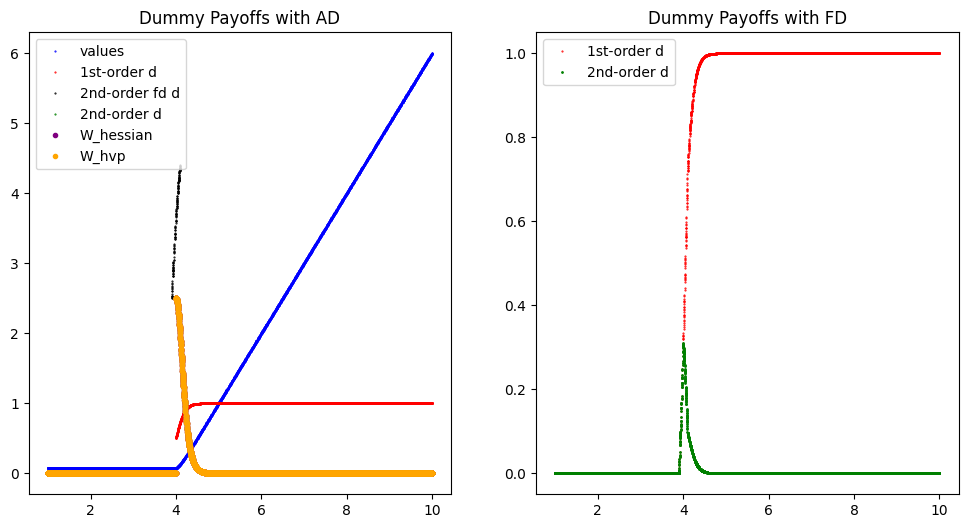

In [6]:
# plt.style.use('seaborn-poster')

def dummy_payoff(xs, K=4):
  return jnp.maximum(0, xs - K)

smoothed_dummy_payoff = sigmoidal_smoothing(dummy_payoff)
dummy_payoff = smoothed_dummy_payoff

seed = 42
n = N_TRAINING_SAMPLES
key = random.PRNGKey(seed)
key, subkey = random.split(key)
xs = random.uniform(subkey, shape=(n,), minval=1.0, maxval=10.0)
ys = dummy_payoff(xs)

dpayoff = grad(dummy_payoff)
dys = vmap(dpayoff)(xs)
ddys = vmap(grad(dpayoff))(xs)

Z_jacobian = jax.vmap(jax.jacobian(dummy_payoff))(xs)
assert(jnp.allclose(dys, Z_jacobian))
W_hessian = jax.vmap(jax.hessian(dummy_payoff))(xs)
assert(jnp.allclose(ddys, W_hessian))

Y_vjp, vjpfun = jax.vjp(dummy_payoff, xs)
basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function

jax.debug.print("Z_jacobian = {jac}", jac=Z_jacobian)
jax.debug.print("Z_vjp_full.shape = {shape}", shape=Z_vjp_full.shape)
jax.debug.print("Z_vjp_full_sum_0 = {vjp}", vjp=jnp.sum(Z_vjp_full, axis=1))


W_hvp = jax.jvp(jax.vmap(jax.grad(dummy_payoff)), (xs, ), (jnp.ones_like(xs), ))[1]
jax.debug.print("W_hvp is {W}", W=W_hvp)

if 0:
    Z_vjp = vjpfun(jnp.ones(Y_vjp.size))[0]
    # if not independent, we need to use the commented out section instead
    basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
    Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    
    jax.debug.print("Z_vjp.shape = {shape}", shape=Z_vjp.shape)
    jax.debug.print("Z_vjp_full.shape = {shape}", shape=Z_vjp_full.shape)
    jax.debug.print("Z_vjp = {vjp}", vjp=Z_vjp)
    # jax.debug.print("Z_vjp_full_sum_0 = {vjp}", vjp=jnp.sum(Z_vjp_full, axis=0))
    # jax.debug.print("Z_vjp_full_sum_1 = {vjp}", vjp=jnp.sum(Z_vjp_full, axis=1))
    
    
    # W_vjp = jax.jvp(vjpfun, jnp.ones_like(Y_vjp)



h = 0.1
fd_xph = vmap(dpayoff)(xs + h)
fd_xmh = vmap(dpayoff)(xs - h)
ddys_fd = (fd_xph - fd_xmh) / (2 * h)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axs[0].set_title("Dummy Payoffs with AD")
axs[0].plot(xs, ys, 'b.', markersize=1, label='values')
axs[0].plot(xs, dys, 'r.', markersize=1, label='1st-order d')
axs[0].plot(xs, ddys_fd, 'k.', markersize=1, label='2nd-order fd d')
axs[0].plot(xs, ddys, 'g.', markersize=1, label='2nd-order d')
axs[0].plot(xs, W_hessian, '.', color='purple', label='W_hessian')
axs[0].plot(xs, W_hvp, '.', color='orange', label='W_hvp')
axs[0].legend()

h = 0.1
fd_xph = dummy_payoff(xs + h)
fd_xmh = dummy_payoff(xs - h)
fd = (fd_xph - fd_xmh) / (2 * h)
fdd = (fd_xph - 2 * ys + fd_xmh) / (2 * h)

# fd_over_fd = (fd_xph - fd_xmh) / (2 * h)

# hs = jnp.diag(jnp.ones_like(xs) * h)
# fd_xph = xs + hs
# fd_xmh = xs - hs
# fd_ = (fd_xph - fd_xmh) / (2 * h)
# fd = jnp.diag(fd_)
# print(xs)
# print(xs + hs)
# print(fd.shape)

# Second plot
axs[1].set_title("Dummy Payoffs with FD")
# axs[1].plot(xs, ys, 'b.', markersize=1, label='values')
# axs[1].plot(xs[:-1], fd, 'b.', markersize=1, label='1st-order d')
axs[1].plot(xs, fd, 'r.', markersize=1, label='1st-order d')
axs[1].plot(xs, fdd, 'g.', markersize=2, label='2nd-order d')
axs[1].legend()

plt.show()

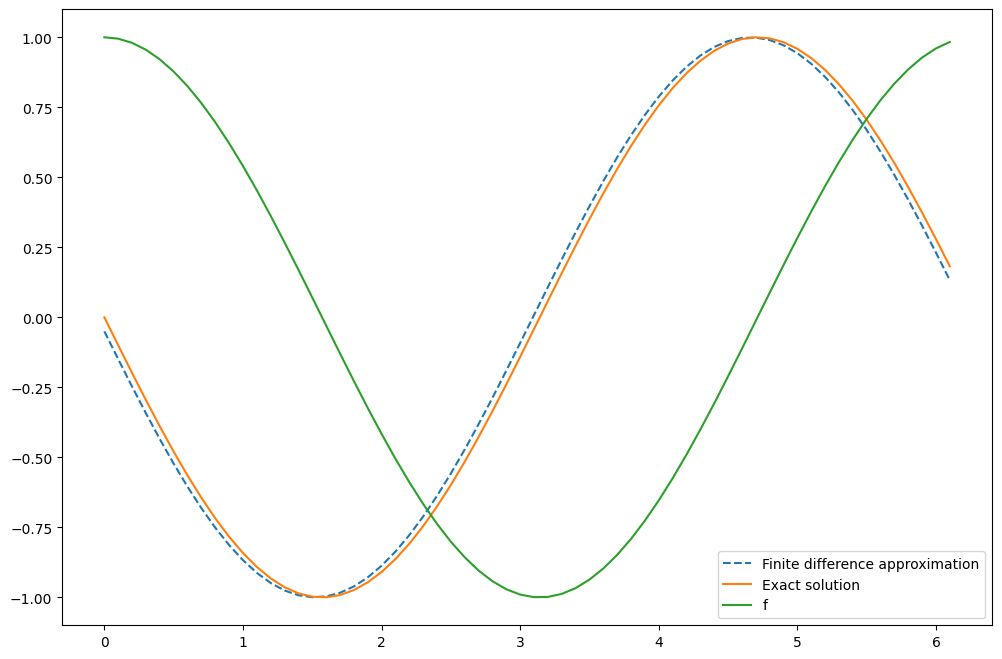

0.049984407218554114


In [7]:
# step size
h = 0.1
# define grid
x = jnp.arange(0, 2*jnp.pi, h) 
# compute function
y = jnp.cos(x) 

# compute vector of forward differences
forward_diff = jnp.diff(y)/h 
# compute corresponding grid
x_diff = x[:-1:] 
# compute exact solution
exact_solution = -jnp.sin(x_diff) 

# Plot solution
plt.figure(figsize = (12, 8))
plt.plot(x_diff, forward_diff, '--', \
         label = 'Finite difference approximation')
plt.plot(x_diff, exact_solution, \
         label = 'Exact solution')
plt.plot(x_diff, jnp.cos(x_diff), label = 'f')
plt.legend()
plt.show()

# Compute max error between 
# numerical derivative and exact solution
max_error = max(abs(exact_solution - forward_diff))
print(max_error)


In [8]:
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)

def bachGamma(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.pdf(d) / (vol * jnp.sqrt(T))
    
# generates a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])


@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = False

class TrainingSet(eqx.Module):
    X: Array 
    Y: Array
    Z: Array
    W: Array
    weights: Array
    inc1: Array
    Z_fd: Array
    W_fd_of_fd: Array
    W_fd_of_vjp: Array
    W_fd_of_grad: Array

    def shapes(self):
        jax.debug.print("X {X}, Y {Y}, Z {Z}, W {W}", X=X.shape, Y=Y.shape, Z=Z.shape, W=W.shape)

class TestSet(eqx.Module):
    spots: Array
    baskets: Array
    prices: Array
    deltas: Array
    vegas: Array
    gammas: Array

def plot_simulations(y0, y1):
  x = jnp.linspace(0, 100, y0.shape[0]) #[..., jnp.newaxis]
  print("X SHAPE: ", x.shape)
  print("Y0 SHAPE: ", y0.shape)
  print("Y1 SHAPE: ", y1.shape)
  plt.title(f"Simulations")
  # for i in range(x.shape[1]):
    # plt.plot(x[:, i], y[:, i], '.', markersize=1, label=f"ddyddx {i}")
  n = 1000
  plt.plot(x[:n], y0[:n])
  plt.plot(x[:n], y1[:n])
  plt.show()


def sigmoidal_smoothing(f, k=250):

    def smooth_f(*args):
        return 1/k * jnp.log(1 + jnp.exp(k * f(*args)))

    return smooth_f


smooth_max = sigmoidal_smoothing(jnp.maximum)
# smooth_max = jnp.maximum

def payoff_fn(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    #pay = jnp.maximum(0, bkt2 - K)
    pay = smooth_max(0, bkt2 - K)
    
    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        # paya = jnp.maximum(0, bkt2a - K)
        paya = smooth_max(0, bkt2a - K)
        
        Y = 0.5 * (pay + paya)
    else: # standard
        Y = pay

    return Y

def analytic_grad(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = jnp.maximum(0, bkt2 - K)

    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = jnp.maximum(0, bkt2a - K)
        
        # differentials
        Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z_analytic = 0.5 * (Z1 + Z2)
                
    else: # standard 
        Z_analytic = jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))

    return Z_analytic
           
# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2) -> TrainingSet:
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult
    anti = params.anti

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)

    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    vols = vols * bktVol / v
    jax.debug.print("vols is= {v}", v=vols)
    bktVol = bktVol
    jax.debug.print("bkt vol is= {v}", v=bktVol)

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))
    inc0 = normals[0, :, :] @ chol0.T
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

      
    payoff = partial(payoff_fn, a=a, K=K, anti=anti)

    Z_analytic = analytic_grad(S1, inc1, a, K, anti=anti)
    # Compute the values and obtain a VJP function
    Y_vjp, vjpfun = jax.vjp(payoff, S1, inc1)
    Z_vjp = vjpfun(jnp.ones(Y_vjp.size))[0]
    # if not independent, we need to use the commented out section instead
    basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
    Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function

    jax.debug.print("Z_vjp.shape = {shape}", shape=Z_vjp.shape)
    jax.debug.print("Z_vjp_full.shape = {shape}", shape=Z_vjp_full.shape)
    jax.debug.print("Z_vjp = {vjp}", vjp=Z_vjp)
    # jax.debug.print("Z_vjp_full_sum_0 = {vjp}", vjp=jnp.sum(Z_vjp_full, axis=0))
    # jax.debug.print("Z_vjp_full_sum_1 = {vjp}", vjp=jnp.sum(Z_vjp_full, axis=1))

    # using first order finite differences
    h = 1e-4
    fd_ph = payoff(S1 + h, inc1)
    fd_mh = payoff(S1 - h, inc1)
    Z_fd = (fd_ph - fd_mh) / (2 * h)

    # using second order finite differences
    h = 1e-2
    fdd = (fd_ph - 2 * Y_vjp + fd_mh) / (h * h)
    W_fd_of_fd = fdd[..., jnp.newaxis]

    # using first order finite difference over vjp
    h = 1e-4
    fd_of_vjp_ph = vjpfun(jnp.ones(Y_vjp.size) + h)[0]
    fd_of_vjp_mh  = vjpfun(jnp.ones(Y_vjp.size) - h)[0]
    W_fd_of_vjp = (fd_of_vjp_ph - fd_of_vjp_mh) / (2 * h)

    Dpayoff = vmap(jax.grad(payoff))
    W_fd_of_grad_ph = Dpayoff(S1 + h, inc1)
    W_fd_of_grad_mh = Dpayoff(S1 - h, inc1)
    W_fd_of_grad = (W_fd_of_grad_ph - W_fd_of_grad_mh) / (2 * h)

    Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    jax.debug.print("W_fd_of_fd vs W_fd_of_vjp {mse}", mse=jnp.mean(jnp.square(W_fd_of_fd - W_fd_of_vjp)))
    jax.debug.print("Example values: {val1}, {val2}", val1=Z_grad[2,0], val2=Z_vjp[2,0])
    jax.debug.print("MSE(Z_grad, Z_analytic) = {res}", res=jnp.mean((Z_grad - Z_analytic)**2))
    jax.debug.print("MSE(Z_vjp, Z_analytic) = {res}", res=jnp.mean((Z_vjp - Z_analytic)**2))
    jax.debug.print("MSE(Y_vjp, Y) = {res}", res=jnp.mean((Y_vjp - Y)**2))
    jax.debug.print("Close(Y_vjp, Y) ? {res}", res=jnp.allclose(Y_vjp, Y))
    jax.debug.print("Close(Z_vjp, Z) ? {res}", res=jnp.allclose(Z_vjp, Z_analytic))
    jax.debug.print("Close(Z_grad, Z) ? {res}", res=jnp.allclose(Z_grad, Z_analytic))

    jax.debug.print("S1.shape {s}", s=S1.shape)

    W_hessian = jax.vmap(jax.hessian(payoff, argnums=0))(S1, inc1)
    
    X = S1
    return TrainingSet(X, Y_vjp.reshape(-1,1), Z_vjp, W_hessian, a, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad)

def testSet(params: BachelierParams, training_set: TrainingSet, n_samples:int=4096, seed:int=42) -> TestSet:
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    weights = training_set.weights
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1)
    gammas = bachGamma(baskets, K, bktVol, T2 - T1)
    return TestSet(spots, baskets, prices, deltas, vegas, gammas) 

# Standard ML

## Data generation

In [9]:
bachelier_params = BachelierParams(n_dim=1, anti=False)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad = astuple(training_set)
print(training_set)

test_set = testSet(bachelier_params, training_set, n_samples=10 * N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)

bkt vol is= 0.2
Z_vjp.shape = (array(8192), array(1))
Z_vjp_full.shape = (array(8192), array(8192), array(1))
S1.shape (array(8192), array(1))
vols is= [0.2]
W_fd_of_fd vs W_fd_of_vjp 0.3870369575712861
MSE(Y_vjp, Y) = 0.0
Example values: 1.0, 1.0
Z_vjp = [[0.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]
MSE(Z_grad, Z_analytic) = 0.0008894603337198279
MSE(Z_vjp, Z_analytic) = 0.0008894603337198279
Close(Z_vjp, Z) ? False
Close(Z_grad, Z) ? False
Close(Y_vjp, Y) ? True
TrainingSet(
  X=f64[8192,1],
  Y=f64[8192,1],
  Z=f64[8192,1],
  W=f64[8192,1,1],
  weights=f64[1],
  inc1=f64[8192,1],
  Z_fd=f64[8192],
  W_fd_of_fd=f64[8192,1],
  W_fd_of_vjp=f64[8192,1],
  W_fd_of_grad=f64[8192,1]
)


In [10]:
bachelier_params = BachelierParams(n_dim=1, anti=False)
training_set = trainingSet(10 * N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad = astuple(training_set)
print(training_set)

test_set = testSet(bachelier_params, training_set, n_samples=10 * N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)


bkt vol is= 0.2
Z_vjp.shape = (array(81920), array(1))
Z_vjp_full.shape = (array(81920), array(81920), array(1))
S1.shape (array(81920), array(1))
vols is= [0.2]
Example values: 0.9971469035006566, 0.9971469035006566
MSE(Z_grad, Z_analytic) = 0.0007703443506557961
MSE(Z_vjp, Z_analytic) = 0.0007703443506557961
Z_vjp = [[0.       ]
 [0.       ]
 [0.9971469]
 ...
 [0.       ]
 [0.       ]
 [0.       ]]
Close(Z_vjp, Z) ? False
Close(Z_grad, Z) ? False
Close(Y_vjp, Y) ? True
MSE(Y_vjp, Y) = 0.0
W_fd_of_fd vs W_fd_of_vjp 0.38598886041339436
TrainingSet(
  X=f64[81920,1],
  Y=f64[81920,1],
  Z=f64[81920,1],
  W=f64[81920,1,1],
  weights=f64[1],
  inc1=f64[81920,1],
  Z_fd=f64[81920],
  W_fd_of_fd=f64[81920,1],
  W_fd_of_vjp=f64[81920,1],
  W_fd_of_grad=f64[81920,1]
)


## Plot generated Data

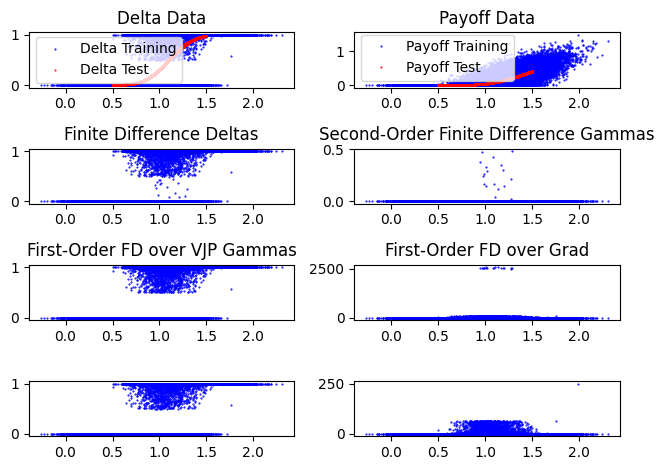

In [11]:

def plot_payoff_data(axs, x_train, y_train, x_test, y_test):
    axs.set_title("Payoff Data")
    axs.plot(x_train, y_train, 'b.', label='Payoff Training', markersize=1)
    axs.plot(x_test, y_test, 'r.', label='Payoff Test', markersize=1)
    axs.legend()

def plot_delta_data(axs, x_train, x_test, dydx_train, dydx_test):
    axs.set_title("Delta Data")
    axs.plot(x_train, dydx_train, 'b.', label='Delta Training', markersize=1)
    axs.plot(x_test, dydx_test, 'r.', label='Delta Test', markersize=1)
    axs.legend()

fig, axs = plt.subplots(4, 2)

Xs = X

plot_payoff_data(axs[0, 1], Xs, Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(axs[0, 0], Xs, baskets[:, 0], Z[:,0], deltas[:,0])

axs[1, 0].set_title("Finite Difference Deltas")
axs[1, 0].plot(Xs, Z_fd, 'b.', label='FD', markersize=1)
axs[1, 1].set_title("Second-Order Finite Difference Gammas")
axs[1, 1].plot(Xs, W_fd_of_fd, 'b.', label='FD', markersize=1)

# not working...
axs[2, 0].set_title("First-Order FD over VJP Gammas")
axs[2, 0].plot(Xs, W_fd_of_vjp, "b.", label='FD', markersize=1)
axs[2, 1].set_title("First-Order FD over Grad")
axs[2, 1].plot(Xs, W_fd_of_grad, "b.", label='FD', markersize=1)

axs[3,0].plot(Xs, Z, "b.", markersize=1)
axs[3,1].plot(Xs, W[:, 0, 0], "b.", markersize=1)
# Adjust the spacing between subplots
plt.tight_layout()

plt.show()


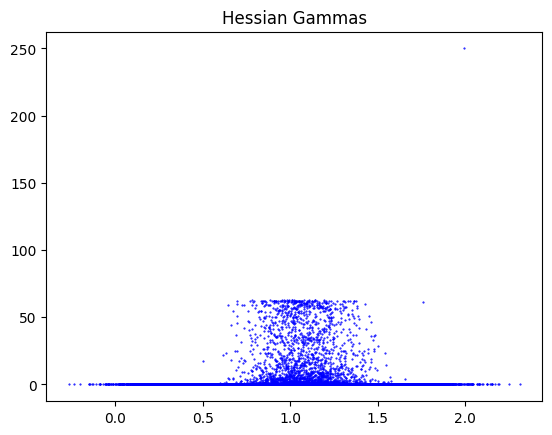

In [12]:
plt.title("Hessian Gammas")
plt.plot(Xs, W[:, :, 0], 'b.', markersize=1)
plt.show()

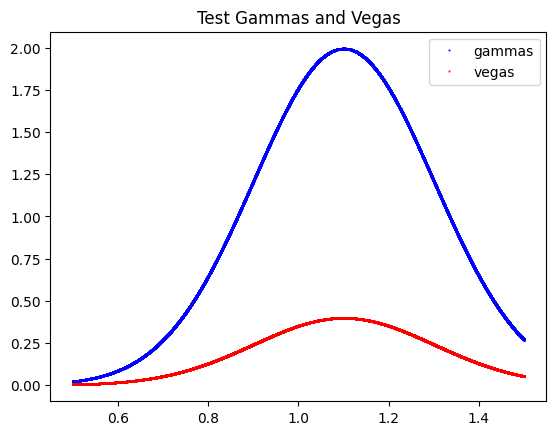

In [13]:
plt.title("Test Gammas and Vegas")
plt.plot(baskets, gammas, 'b.', markersize=1, label='gammas')
plt.plot(baskets, vegas, 'r.', markersize=1, label='vegas')
plt.legend()
plt.show()

In [14]:
use_anti = True
bachelier_params = BachelierParams(n_dim=7, anti=use_anti)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K, anti=use_anti)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.2
Z_vjp.shape = (array(8192), array(7))
Z_vjp_full.shape = (array(8192), array(8192), array(7))
S1.shape (array(8192), array(7))
vols is= [1.05260847 0.42256553 0.57476578 0.95103314 0.54402614 0.15129556
 0.66726668]
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True
Example values: 0.0, 0.0
W_fd_of_fd vs W_fd_of_vjp 0.007795986419153547
MSE(Z_grad, Z_analytic) = 1.1435290120249788e-05
MSE(Z_vjp, Z_analytic) = 1.1435290120249788e-05
Close(Z_vjp, Z) ? False
Close(Z_grad, Z) ? False
Z_vjp = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.03523608 0.1942886  0.20768846 ... 0.0497394  0.07701987 0.22790145]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01761804 0.0971443  0.10384423 ... 0.0248697  0.03850994 0.11395073]
 [0.03523608 0.1942886  0.20768846 ... 0.0497394  0.07701987 0.22790145]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [131]:
k_samples = 2
k_start = 5000
k_end = k_start + k_samples
x_sample = X[k_start:k_end, :]
inc1_sample = inc1[k_start:k_end, :]
y_sample = Y[k_start:k_end, :]
z_sample = Z[k_start:k_end, :]
w_sample = W[k_start:k_end, :]


n_dim = x_sample.shape[-1]
seed = jnp.eye(n_dim) 
rep_seed = jnp.repeat(seed, k_samples, axis=0)
rep_seed = jnp.reshape(rep_seed, (7, k_samples, 7))
print(rep_seed)

[[[1. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]]

 [[0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 1.]]]


In [142]:
k_samples = 2
k_start = 5000
k_end = k_start + k_samples
x_sample = X[k_start:k_end, :]
inc1_sample = inc1[k_start:k_end, :]
y_sample = Y[k_start:k_end, :]
z_sample = Z[k_start:k_end, :]
w_sample = W[k_start:k_end, :]

print(payoff(x_sample, inc1_sample).shape)

jax.debug.print("x_sample.shape = {}", x_sample.shape)
jax.debug.print("inc1_sample.shape = {}", inc1_sample.shape)
jax.debug.print("z_sample.shape is {}", z_sample.shape)
print("z_samples ", z_sample)
jax.debug.print("w_sample.shape is {}", w_sample.shape)
print("w_samples ", w_sample)

dpayoff_ad = eqx.filter_value_and_grad(payoff)
y_ad, dy_ad = vmap(dpayoff_ad)(x_sample, inc1_sample)
assert(jnp.allclose(y_sample, y_ad[..., jnp.newaxis]))


dpayoff_v = vmap(eqx.filter_grad(payoff))
dy_v_ad, ddy_fn = jax.vjp(dpayoff_v, x_sample, inc1_sample)
assert(jnp.allclose(dy_v_ad, z_sample))

ddy_v_ad = vmap(ddy_fn)(jnp.ones((7,2,7)))[0]
ddy_v_ad = jnp.transpose(ddy_v_ad, (1, 0, 2))
jax.debug.print("ddy_v_ad.shape {}", ddy_v_ad.shape)
# print("ddy_v_ad ", ddy_v_ad)


ddy_fwd_ad = jax.jacfwd(dpayoff_v)(x_sample, inc1_sample)
ddy_fwd_ad = jnp.sum(ddy_fwd_ad, axis=2)
assert(jnp.allclose(ddy_fwd_ad, w_sample))
jax.debug.print("ddy_fwd_ad.shape {}", ddy_fwd_ad.shape)
print("ddy_fwd_ad ", ddy_fwd_ad)


def jacfwd_custom_seed(f):
    def jacfun(x, seed_matrix):
        _jvp = lambda s: jax.jvp(f, (x,), (s,))[1]
        Jt = vmap(_jvp, in_axes=1)(seed_matrix)
        return jnp.transpose(Jt)
    return jacfun

ddy_fwd_custom = jacfwd_custom_seed(partial(dpayoff_v, inc1=inc1_sample))(x_sample, seed_matrix=jnp.ones((2, 7, 7)))

single_jvp = jax.jvp(dpayoff_v, (x_sample, inc1_sample), (jnp.zeros_like(x_sample).at[:,1].set(1.0), jnp.zeros_like(inc1_sample)))[1]
jax.debug.print("single_jvp.shape {}", single_jvp.shape)
print("single_jvp: ", single_jvp)


def jmp(df, x_sample, inc1_sample):

    def jvp_(v):
        return jax.jvp(df, (x_sample, inc1_sample), (v, jnp.zeros_like(x_sample)))

    return jvp_

print(jnp.eye(x_sample.shape[-1]))
print(jnp.zeros_like(x_sample).at[:,0].set(1.0))


jvp_ = jmp(dpayoff_v, x_sample, inc1_sample)


n_dim = x_sample.shape[-1]
seed = jnp.eye(n_dim) 
rep_seed = jnp.repeat(seed, k_samples, axis=0)
rep_seed = jnp.reshape(rep_seed, (7, k_samples, 7))
ddy_fwd = vmap(jvp_)(rep_seed)
ddy_fwd = jnp.transpose(ddy_fwd[1], (1, 0, 2))
assert(jnp.allclose(ddy_fwd, w_sample))

print("ddy_fwd.shape ", ddy_fwd.shape)
print("ddy_fwd ", ddy_fwd)

# primals = jnp.zeros_like 
# jax.jvp(dy_fn, primals, tangents, has_aux=True)

                    
if 0:
    y_vjp, dyfun = jax.vjp(partial(payoff, inc1=inc1_sample), x_sample)
    dy_vjp = dyfun(jnp.ones_like(y_vjp))[0]
    # jax.debug.print("dy_vjp is {}", dy_vjp)
    assert(jnp.allclose(dy_vjp, z_sample))
    # y_partial_ad, dy_partial_ad = vmap(dpayoff_partial_ad)(x_sample)
    
    # jax.debug.print("y {}", y_vjp)
    assert(jnp.allclose(y_ad, y_vjp))
    
    
    y_aux, dyfun_aux = jax.vjp(payoff, x_sample, inc1_sample)
    jax.debug.print("y_aux.shape = {}", y_aux.shape)
    
    # the second tuple entry is w.r.t the inc1 samples which we do not care about. Might want to consider using has_aux=True with a dummy output.
    dy_aux, _ = dyfun_aux(jnp.ones_like(y_aux))
    jax.debug.print("dy_aux {}", dy_aux.shape)
    jax.debug.print("dy_aux {}", dy_aux)
    # jax.debug.print("z {}", z_sample)
    
    assert(jnp.allclose(dy_aux, z_sample))
    
    # instead, compute full jacobian now
    basis = jnp.eye(y_aux.shape[-1], dtype=y_aux.dtype)
    J_vjp = vmap(dyfun_aux)(basis)[0]
    jax.debug.print("J_vjp is {}", J_vjp.shape)
    jax.debug.print("J_vjp is {}", J_vjp)
    
    
    # primals = (jnp.ones_like(y_aux), )
    primals = (jnp.zeros_like(y_aux).at[0].set(1.0), )
    tangents = (jnp.zeros_like(y_aux).at[0].set(1.0), )
    
    jax.debug.print("tangents {}", tangents)
    dy_aux2, ddy_aux2, aux = jax.jvp(dyfun_aux, primals, tangents, has_aux=True)
    #assert(jnp.allclose(dy_aux2, z_sample))
    # jax.debug.print("dy_aux2 {}", dy_aux2)
    jax.debug.print("dy_aux2 {}", dy_aux2)
    jax.debug.print("ddy_aux2 {}", ddy_aux2)
    jax.debug.print("aux is {}", aux.shape)
    jax.debug.print("w is {}", w_sample)
    
    
    def hvp(f, primals, tangents):
        return jax.jvp(eqx.filter_grad(f), primals, tangents, has_aux=False)[1]
    
    def hmp(f, primals):
        
        def hvp_(tangents):
            return hvp(f, (primals,), (tangents, ))
    
        return eqx.filter_vmap(hvp_)
    
    def batch_hmp(f):
    
        def hvp_(primals, tangents):
            return hvp(f, (primals,), (tangents,))
    
        return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))
    
    
    def hvp_(f, primals, tangents):
        return jax.jvp(f, primals, tangents, has_aux=True)[1]
    
    
    print(y_aux.shape)
    hvp_(dyfun_aux, (jnp.ones_like(y_aux), ), (jnp.zeros_like(y_aux).at[1].set(1.0), ))
    # hmp(payoff, x_sample)(jnp.eye(7))
    # batch_hmp(partial(payoff, inc1=inc1_sample))(x_sample, jnp.eye(7))
    
    
    if 1:
        batch_hmp_fn = vmap(batch_hmp(partial(payoff, inc1=inc1_sample)))
        basis = jnp.eye(x_sample.shape[-1], dtype=x_sample.dtype)
        print(basis.shape)
        print(x_sample.shape)
        hmp_res = batch_hmp_fn(x_sample, basis)
        hmp_res = jnp.transpose(hmp_res, (1, 0, 2))
        jax.debug.print("hmp_res is {}", hmp_res)
    elif 0:
        batch_hmp_fn = batch_hmp(MakeScalar(payoff))
        basis = jnp.eye(x_sample.shape[-1], dtype=x_sample.dtype)
        hmp_res = batch_hmp_fn(x_sample, inc1_sample, basis)
        hmp_res = jnp.transpose(hmp_res, (1, 0, 2))
        jax.debug.print("hmp_res is {}", hmp_res)
    else:
        batch_hmp_fn = batch_hmp(partial(payoff, inc1=inc1_sample))
        basis = jnp.eye(x_sample.shape[-1], dtype=x_sample.dtype)
        hmp_res = batch_hmp_fn(x_sample, basis)
        hmp_res = jnp.transpose(hmp_res, (1, 0, 2))
        jax.debug.print("hmp_res is {}", hmp_res)

# batched_payoff = batch_hmp(partial(payoff, inc1=inc1_sample)) 
# basis = jnp.eye(x_sample.shape[-1], dtype=x_sample.dtype)
# print(basis.shape)
# batched_payoff(x_sample, basis)

# batched_payoff = batch_hmp(payoff) 
# basis = jnp.eye(x_sample.shape[-1], dtype=x_sample.dtype)
# print(basis.shape)
# batched_payoff(x_sample, inc1_sample, (jnp.ones(shape=(7, 7)), jnp.ones(shape=(7, 1))))

# ---
# jax.debug.print("y_aux.shape is {}", y_aux.shape)
# ddy_aux_fwd = jax.jacfwd(dyfun_aux)(jnp.ones(shape=(7, )))
# jax.debug.print("ddy_aux_fwd.shape is {}", ddy_aux_fwd[1].shape)

#primals = ((x_sample, inc1_sample),)
#tangents = ((jnp.ones_like(x_sample),jnp.ones_like(inc1_sample),))
# jax.debug.print("primals type {}", type(payoff))
# jax.debug.print("tangents type {}", type(tangents))
# single_jvp_test = eqx.filter_jvp(vmap(dpayoff_ad), primals, tangents)

(2,)
x_sample.shape = (2, 7)
inc1_sample.shape = (2, 7)
z_sample.shape is (2, 7)
z_samples  [[0.03523604 0.19428835 0.20768819 0.20812588 0.04973933 0.07701978
  0.22790116]
 [0.01761804 0.0971443  0.10384423 0.10406307 0.0248697  0.03850994
  0.11395073]]
w_sample.shape is (2, 7, 7)
w_samples  [[[3.93004323e-07 2.16699068e-06 2.31644553e-06 2.32132730e-06
   5.54766526e-07 8.59038314e-07 2.54189043e-06]
  [2.16699068e-06 1.19485928e-05 1.27726735e-05 1.27995911e-05
   3.05893300e-06 4.73666042e-06 1.40157565e-05]
  [2.31644553e-06 1.27726735e-05 1.36535900e-05 1.36823641e-05
   3.26990409e-06 5.06334243e-06 1.49824070e-05]
  [2.32132730e-06 1.27995911e-05 1.36823641e-05 1.37111988e-05
   3.27679520e-06 5.07401310e-06 1.50139815e-05]
  [5.54766526e-07 3.05893300e-06 3.26990409e-06 3.27679520e-06
   7.83110721e-07 1.21262203e-06 3.58814304e-06]
  [8.59038314e-07 4.73666042e-06 5.06334243e-06 5.07401310e-06
   1.21262203e-06 1.87770663e-06 5.55612532e-06]
  [2.54189043e-06 1.40157565e-05

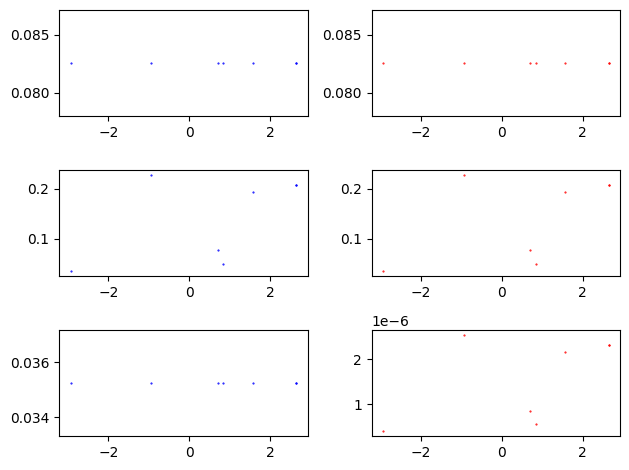

In [33]:

fig, axs = plt.subplots(3, 2)
axs[0, 0].plot(x_sample, y_ad, "b.", markersize=1)
axs[0, 1].plot(x_sample, y_sample, "r.", markersize=1)
axs[1, 0].plot(x_sample, dy_aux, "b.", markersize=1)
axs[1, 1].plot(x_sample, z_sample, "r.", markersize=1)
axs[2, 0].plot(x_sample, ddy_aux2[:, 0], "b.", markersize=1)
axs[2, 1].plot(x_sample, w_sample[:, 0, :], "r.", markersize=1) 
plt.tight_layout()

plt.show()


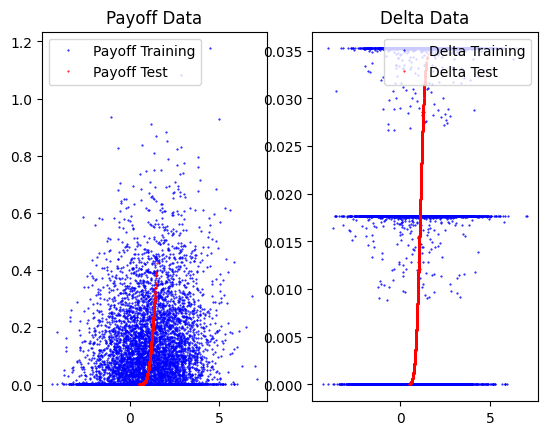

In [34]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

## Train Standard ML

In [16]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [17]:
x_train = X
y_train = Y
dydx_train = Z

In [18]:
# Hyperparameters
# batch_size = 128
# learning_rate = 0.01
num_epochs = NUM_EPOCHS
seed = 42

key = jax.random.PRNGKey(seed)

In [19]:
def x_normalizer(x):
    return (x - x_train_mean) / x_train_std

def y_denormalizer(x):
    return x * y_train_std + y_train_mean

class MLP_Normalized(eqx.Module):
    layers: list

    def __init__(self, key, in_size, out_size):
        key, subkey = jax.random.split(key)
        self.layers = [x_normalizer, 
                       eqx.nn.MLP(key=subkey, in_size=in_size, out_size=out_size, width_size=20, depth=3, activation=jax.nn.elu), 
                       y_denormalizer]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [20]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  # print(out, in_)
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model


In [21]:
def mean_squared_error(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.mean((y - pred_y) ** 2)

In [22]:
@jit
def rmse(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.sqrt(jnp.mean((y - pred_y) ** 2))

In [23]:
class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

In [24]:
@eqx.filter_jit
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    pred_y = vmap(MakeScalar(model))(x)
    pred_y = pred_y[:, jnp.newaxis]
    result = mean_squared_error(y, pred_y)
    return result

In [25]:
def evaluate(model, testloader):
    """
    This function evaluates the model on the test dataset,
    computing both the average loss.
    """
    avg_loss = 0
    for (x, y, _) in testloader:
        avg_loss += loss_fn(model, x, y)
    return avg_loss / len(testloader)

In [26]:
def train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, _) in generator_train_ds:

            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y)

        test_loss = evaluate(model, generator_test_ds)
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [28]:
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

# use linear on-cycle decay scheduler
num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
# print(total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=1000., final_div_factor=1.0e4)


lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)

# lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
# lr_schedule = optax.constant_schedule(0.0001)
# lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# optim = optax.adam(learning_rate=0.001)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=lr_schedule)
# model = MakeScalar(model)
model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.00560  | Test Loss: 0.00143
Finished epoch   1  | Train Loss: 0.00414  | Test Loss: 0.00127
Finished epoch   2  | Train Loss: 0.00326  | Test Loss: 0.00083
Finished epoch   3  | Train Loss: 0.00287  | Test Loss: 0.00073
Finished epoch   4  | Train Loss: 0.00279  | Test Loss: 0.00064
Finished epoch   5  | Train Loss: 0.00243  | Test Loss: 0.00052
Finished epoch   6  | Train Loss: 0.00198  | Test Loss: 0.00042
Finished epoch   7  | Train Loss: 0.00170  | Test Loss: 0.00034
Finished epoch   8  | Train Loss: 0.00209  | Test Loss: 0.00028
Finished epoch   9  | Train Loss: 0.00160  | Test Loss: 0.00023
Finished epoch  10  | Train Loss: 0.00172  | Test Loss: 0.00019
Finished epoch  11  | Train Loss: 0.00183  | Test Loss: 0.00014
Finished epoch  12  | Train Loss: 0.00143  | Test Loss: 0.00012
Finished epoch  13  | Train Loss: 0.00151  | Test Loss: 0.00009
Finished epoch  14  | Train Loss: 0.00174  | Test Loss: 0.00008
Finished epoch  15  | Train Loss: 0.0015

In [29]:
class Predictions(eqx.Module):
    y: Array
    dydx: Array
    ddyddx: Array

def predict(model, xs):
    pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(xs)
    pred_ddyddx = vmap(jax.hessian(MakeScalar(model)))(xs)

    return Predictions(pred_y, pred_dydx, pred_ddyddx)
    

In [30]:
pred = predict(model, x_test)

## Plot results

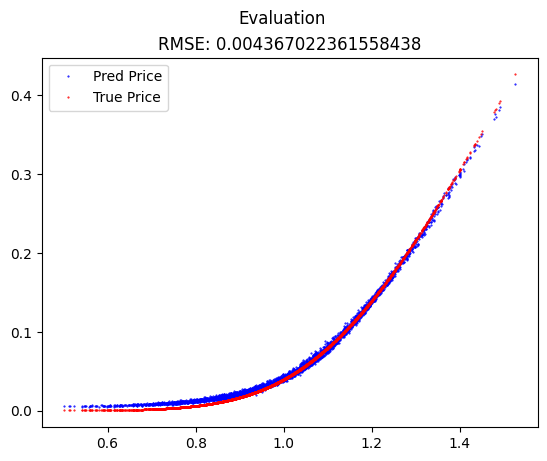

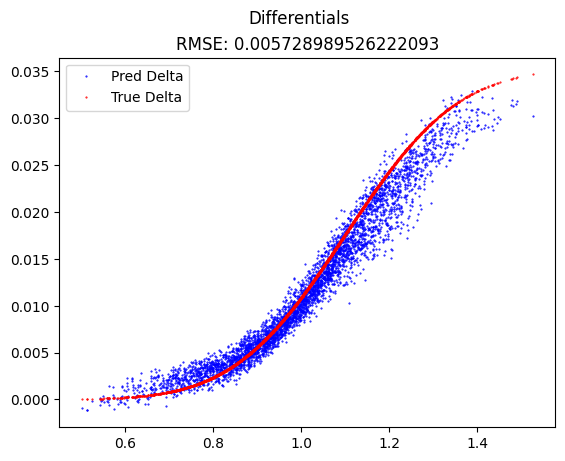

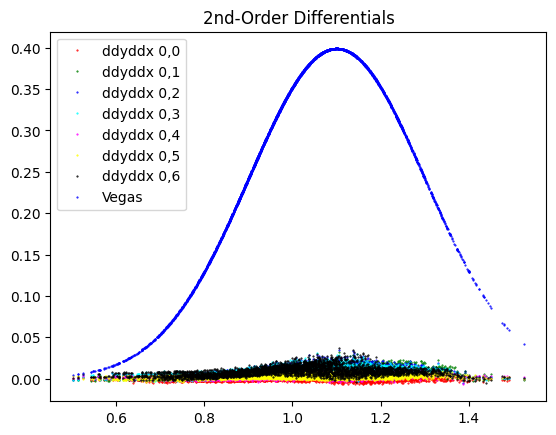

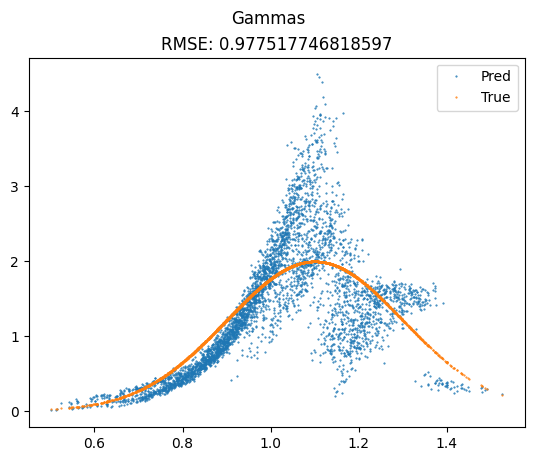

In [31]:
def plot_eval(model, pred: Predictions, test_set: TestSet):

    def print_rmse(pred, true):
        plt.title(f"RMSE: {rmse(true, pred)}")

    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]

    print_rmse(pred_y, y_test)

    plt.suptitle("Evaluation")
    plt.plot(baskets, pred_y, 'b.', markersize=1)
    plt.plot(baskets, y_test, 'r.', markersize=1)
    plt.legend(['Pred Price', 'True Price'], loc='upper left')
    plt.show()

    print_rmse(pred_dydx, dydx_test)

    plt.suptitle("Differentials")
    dydx_idx = 0
    plt.plot(baskets, pred_dydx[:, dydx_idx], 'b.', markersize=1)
    plt.plot(baskets, dydx_test[:, dydx_idx], 'r.', markersize=1)
    plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
    plt.show()

    colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray']
    plt.title("2nd-Order Differentials")
    for i in range(baskets.shape[-1]):
        for j in range(pred_ddyddx.shape[1]):
            plt.plot(baskets, pred_ddyddx[:, i, j], '.', color=colors[j % len(colors)], markersize=1, label=f"ddyddx {i},{j}")

    plt.plot(baskets, vegas, 'b.', markersize=1, label="Vegas")
    plt.legend()
    plt.show()

    pred_gammas = jnp.sum(pred.ddyddx, axis=(1, 2))

    print_rmse(pred_gammas, gammas)
    plt.suptitle("Gammas")
    plt.plot(baskets, pred_gammas, '.', markersize=1, label='Pred')
    plt.plot(baskets, gammas, '.', markersize=1, label='True')
    plt.legend()
    plt.show()

plot_eval(model, pred, test_set)

## Learning Rate Schedule

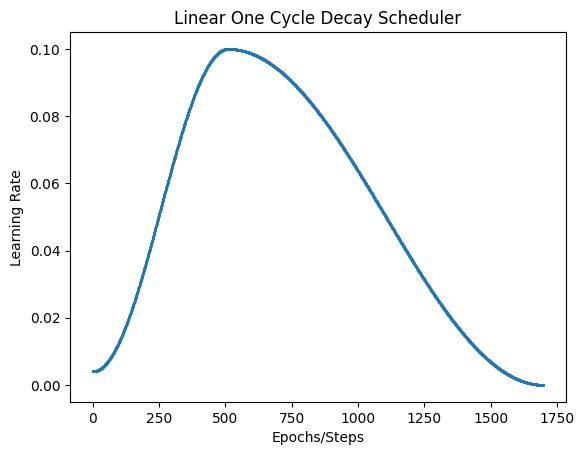

In [32]:

lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
                                                                 pct_start=0.2, pct_final=0.6,
                                                                 div_factor=10., final_div_factor=1.0e6)


lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)

lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.1)

lrs = vmap(lr_schedule)(jnp.arange(total_steps))
plt.scatter(range(total_steps), lrs, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

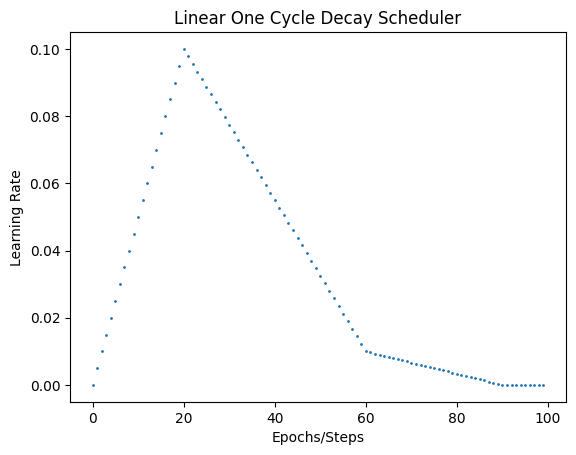

In [33]:
# this is the learning rate used by Savine et al.
lr_data = jnp.array([1e-08, 0.0050000095, 0.010000009, 0.0150000085, 0.020000008000000003, 0.025000007500000004, 0.030000007000000002, 0.03500000650000001, 0.040000006000000005, 0.0450000055, 0.05000000500000001, 0.055000004500000005, 0.060000004, 0.0650000035, 0.070000003, 0.0750000025, 0.080000002, 0.0850000015, 0.090000001, 0.0950000005, 0.1, 0.09775, 0.0955, 0.09325, 0.09100000000000001, 0.08875000000000001, 0.08650000000000001, 0.08425, 0.082, 0.07975000000000002, 0.07750000000000001, 0.07525000000000001, 0.07300000000000001, 0.07075000000000001, 0.0685, 0.06625, 0.064, 0.061750000000000006, 0.059500000000000004, 0.057249999999999995, 0.05499999999999999, 0.052750000000000005, 0.0505, 0.04825, 0.046, 0.04375, 0.041499999999999995, 0.03925000000000001, 0.037000000000000005, 0.03475, 0.0325, 0.03025, 0.027999999999999997, 0.025749999999999995, 0.023499999999999993, 0.02124999999999999, 0.01899999999999999, 0.01675, 0.014499999999999999, 0.012249999999999997, 0.01, 0.0096667, 0.0093334, 0.009000099999999999, 0.008666799999999999, 0.008333499999999999, 0.008000199999999999, 0.007666899999999998, 0.007333599999999997, 0.007000300000000001, 0.006667000000000001, 0.006333700000000001, 0.0060004, 0.0056671000000000004, 0.0053338, 0.0050005, 0.0046672, 0.004333899999999999, 0.004000599999999999, 0.0036672999999999983, 0.0033339999999999984, 0.0030006999999999976, 0.002667400000000001, 0.0023341000000000013, 0.0020008000000000005, 0.0016675000000000006, 0.0013342000000000007, 0.0010009000000000007, 0.0006675999999999991, 0.0003342999999999992, 1e-06, 9.009999999999998e-07, 8.019999999999997e-07, 7.029999999999997e-07, 6.040000000000005e-07, 5.050000000000005e-07, 4.0600000000000033e-07, 3.070000000000002e-07, 2.0800000000000006e-07, 1.0899999999999993e-07])
plt.scatter(range(len(lr_data)), lr_data, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

# Differential ML

## Data generation

In [34]:
@eqx.filter_jit
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    value_loss = alpha * jnp.mean((y_pred - y)**2)
    grad_loss = beta * jnp.mean((dydx_pred - dydx)**2)
    loss = value_loss + grad_loss

    # jax.debug.print('[Internal] Value Loss {value_loss} | Grad Loss: {grad_loss}', value_loss=value_loss, grad_loss=grad_loss)
    return loss

In [35]:
def optimal_step(x: Float):
    h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
    return h * jnp.fabs(x)

## Train

In [36]:
def diff_train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, batch_dydx) in generator_train_ds:
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

        test_loss = rmse(vmap(model)(x_test), y_test)
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

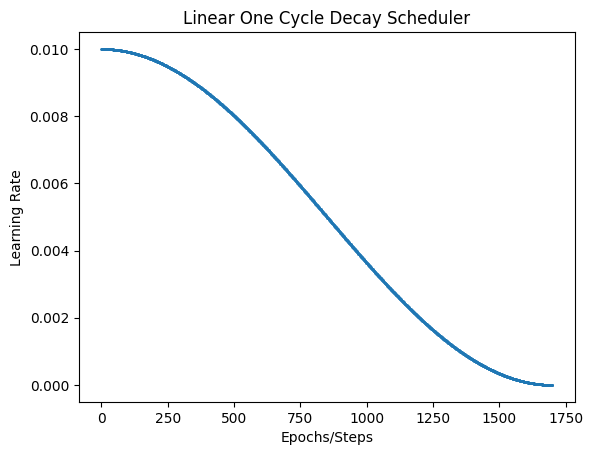

In [37]:
# linear_onecycle_decay_scheduler = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=100., final_div_factor=1.0e6)

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                 pct_start=0.2, pct_final=0.6,
#                                                 div_factor=100., final_div_factor=1.0e6)

lrs = vmap(lr_schedule)(jnp.arange(total_steps))
plt.scatter(range(total_steps), lrs, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

In [38]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [39]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [40]:
optim = optax.adam(learning_rate=lr_schedule)
model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=100)

Finished epoch   0  | Train Loss: 0.00127  | Test Loss: 0.01890
Finished epoch   1  | Train Loss: 0.00105  | Test Loss: 0.00680
Finished epoch   2  | Train Loss: 0.00105  | Test Loss: 0.00483
Finished epoch   3  | Train Loss: 0.00096  | Test Loss: 0.00428
Finished epoch   4  | Train Loss: 0.00101  | Test Loss: 0.00825
Finished epoch   5  | Train Loss: 0.00100  | Test Loss: 0.00438
Finished epoch   6  | Train Loss: 0.00094  | Test Loss: 0.00563
Finished epoch   7  | Train Loss: 0.00098  | Test Loss: 0.00199
Finished epoch   8  | Train Loss: 0.00101  | Test Loss: 0.00659
Finished epoch   9  | Train Loss: 0.00097  | Test Loss: 0.00445
Finished epoch  10  | Train Loss: 0.00096  | Test Loss: 0.00288
Finished epoch  11  | Train Loss: 0.00100  | Test Loss: 0.00374
Finished epoch  12  | Train Loss: 0.00099  | Test Loss: 0.00424
Finished epoch  13  | Train Loss: 0.00097  | Test Loss: 0.00332
Finished epoch  14  | Train Loss: 0.00092  | Test Loss: 0.00222
Finished epoch  15  | Train Loss: 0.0009

## Plot results

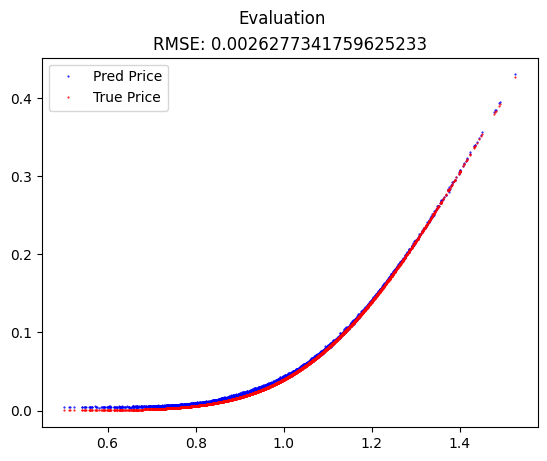

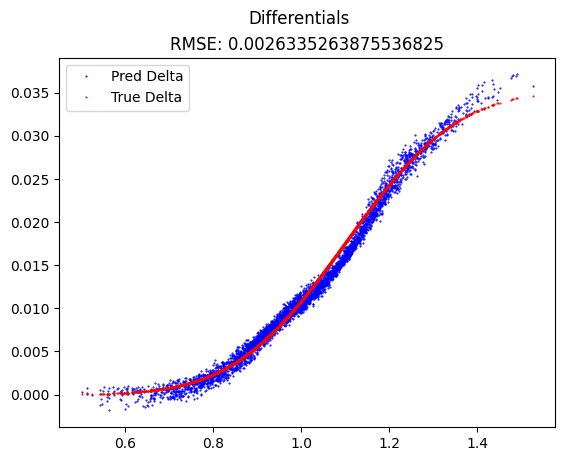

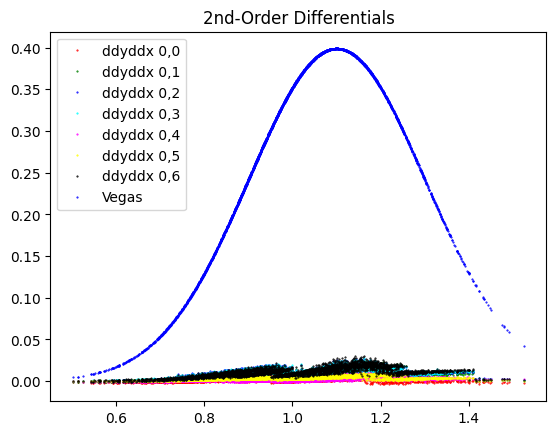

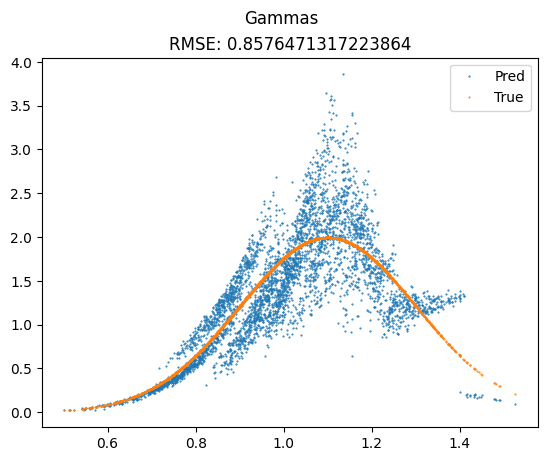

In [41]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

# Differential ML with PCA

## Data generation

In [42]:
def hvp(f, primals, tangents):
    return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

def hmp(f, primals):
    
    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

def batch_hmp(f):

    def hvp_(primals, tangents):
        return hvp(f, (primals,), (tangents,))

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))
    # return eqx.filter_jit(eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1)))

# jax cannot deal with dynamic slices of arrays
# therefore, we cannot simply slice the principal_components array while using batch_hmp

# this is a version where a 0 vector principal component will lead to a different path (namely returning 0) compared to computing a hvp.
def cond_fn_pca(tangents, *args):
    # xs, cum_sum = x
    # return cum_sum > 0.95

    # jax.debug.print("tangents {tangents}", tangents=tangents)

    return jnp.any(tangents[0] > 0.0)  # NOTE: we set the tangents to zero if we do not want to compute its derivative (because principle component is too small)

def hvp_pca(f, primals, tangents):
    return jax.lax.cond(cond_fn_pca(tangents), lambda _: hvp(f, primals, tangents), lambda _: tangents[0], None)

def batch_hmp_select(f):

    def hvp_(primals, tangents):
        return hvp_pca(f, (primals,), (tangents,))

    # x = jnp.zeros(shape=(1, 1))
    # jax.lax.while_loop(cond_fn_pca, fn, (x, 0.0)) # not reverse-mode differentiable!
    # jnp.piecewise(x, cond_fn_pca, fn, (x, 0.0)) # not reverse-mode differentiable!

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))

# this is a version where we explicitly add a list of boolean values, indicating whether we should compute the hvp or not
def hvp_conditional(f, primals, tangents, eval_hvp):
    # jax.debug.print("primals {x}", x=primals)
    # jax.debug.print("tangents {x}", x=tangents)
    # jax.debug.print("eval_hvp {x}", x=eval_hvp)

    # jax.lax.cond(eval_hvp, lambda _: jax.debug.print("using hvp: {eval}", eval=eval_hvp), lambda _: jax.debug.print("not using hvp: {eval}", eval=~eval_hvp), None)

    # res = hvp(f, primals, tangents)
    # jax.debug.print("evalhvp.shape {res}", res=res.shape)
    return jax.lax.cond(eval_hvp, lambda _: hvp(f, primals, tangents), lambda _: jnp.zeros(shape=(primals[0].shape[-1],)), None)

def batch_hmp_cond(f):

    def hvp_(primals, tangents, eval_hvp):
        return hvp_conditional(f, (primals,), (tangents,), eval_hvp)

    return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None, None)), in_axes=(None, 1, 0))


In [43]:
def test_fn(x, ys, ts):
    jax.debug.print("x {x}", x=x)
    jax.debug.print("ys {ys}", ys=ys)
    jax.debug.print("ts {ts}", ts=ts)

    return ys + ts

xs_test = jnp.array([1.0, 2.0])
ys = jnp.array([[1.0, 2.0], [3.0, 4.0]])
ts = jnp.array([[5.0, 6.0], [7.0, 8.0]])

vmap(test_fn, in_axes=(None, 0, 0))(xs_test, ys, ts)


x [1. 2.]
ys [1. 2.]
ys [3. 4.]
ts [5. 6.]
ts [7. 8.]


Array([[ 6.,  8.],
       [10., 12.]], dtype=float64)

In [166]:
key = jax.random.PRNGKey(0)
sv = jnp.array([0.35, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1])
pc = jax.random.uniform(key, shape=(7,7))
print(pc.shape)
print(x_train.shape)

compute = ~(jnp.cumsum(sv) > 0.95)
# compute  = jnp.array([1., 2., 3., 4., 5., 6., 7.])

hmp_batch_cond_fn = batch_hmp_cond(MakeScalar(model))
res = hmp_batch_cond_fn(x_train, pc, compute)
print(res.shape)
print(res[-1])

(7, 7)
(8192, 7)
(7, 8192, 7)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [60]:
from enum import Enum

class dydx_type(Enum):
    Default = 1
    MeanAdjusted = 2
    PCA = 3
    PCA_Reduced = 4


def plot_singular_values(S):
    plt.title("Singular Values of Gradient")
    plt.plot(S, 'r', markersize=0)
    plt.show()


def plot_dydx_pred(x, dydx_pred, title):
   
    if title == dydx_type.Default.value:
        plt.title("Predicted Gradients of all Dimensions")
    elif title == dydx_type.MeanAdjusted.value: 
        plt.title("Predicted Gradients of all Dimensions | Mean Adjusted")
    elif title == dydx_type.PCA.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reconstruction")
    elif title == dydx_type.PCA_Reduced.value: 
        plt.title("Predicted Gradients of all Dimensions | PCA reduced")
    else:  
        plt.title("Predicted Gradients of all Dimensions")

    for i in range(dydx_pred.shape[1]):
        plt.plot(x[:, i], dydx_pred[:, i], '.', markersize=1)
    plt.show()


def plot_dydx_pred_individual_dims(x, dydx, dydx_pred, dydx_pred_pca, principal_components, pc_scaled):

    for i in range(x.shape[1]):

        plt.title(f"Differentials Dimension {i}")
        plt.plot(x[:, i], dydx[:, i], 'r.', markersize=1, label="True")
        plt.plot(x[:, i], dydx_pred[:, i], 'b.', markersize=1, label="Pred")
        plt.legend()
        plt.show()

        # variance within the dimesions:
        plt.title(f"Variance of Dim {i} (y-axis) w.r.t Dim 0 (x-axis))")
        plt.plot(dydx_pred_pca[:, 0], dydx_pred_pca[:, i], 'b.', markersize=1)


        colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray']
        for j, _ in enumerate(principal_components):
            plt.plot(np.array([0, 0 + pc_scaled[j, 0]]),
                    np.array([0,  0 + pc_scaled[j, i]]), '-',  color=colors[j % len(colors)], linewidth=5, label=f"PC{j}")

        plt.legend()
        plt.show()


# def plot_ddyddx(x, ddyddx):
#   plt.title("Gammas ")
#   dydx_idx = 0
#   for i in range(x_test.shape[1]):
#     for j in range(x_test.shape[1]):
#       plt.plot(baskets, pred_ddyddx[:, i, j], '.', markersize=1, label=f"Gamma {i},{j}")
#   plt.legend(loc='upper left')
#   plt.show()

colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white', 'orange', 'purple', 'brown', 'pink', 'gray']

def plot_ddyddx_pred(x, ddyddx):
  for i in range(x.shape[1]):
    plt.title(f"2nd-Order Differential Predictions {i}")

    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j % len(colors)], label=f"ddyddx {i},{j}")
    plt.show()


def plot_ddyddx_pred_hvp(x, ddyddx):
  plt.title(f"2nd-Order Differential HVP Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd(x, ddyddx):
  plt.title(f"2nd-Order Finite-Difference Predictions")
  for i in range(x.shape[1]):
    for j in range(ddyddx.shape[1]):
      plt.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
  plt.show()

def plot_ddyddx_fd_of_grad(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_grad_full(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over Grad Full Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()

def plot_ddyddx_fd_of_fd(x, ddyddx):
  plt.title(f"1st-Order Finite-Difference over FD Predictions")
  for i in range(x.shape[1]):
    plt.plot(x[:, i], ddyddx[:, i], '.', markersize=1, label=f"ddyddx {i}")
  plt.show()


def plot_hesse_model_vs_data(x, hesse_model, hesse_data):
  plt.title(f"Hesse Model vs Data")

  # for now we only consider one dimension
  for i in range(x.shape[-1]):
    lines_x = jnp.array([x[:, i], x[:, i]])
    lines_y = jnp.array([hesse_model[:, i, 0], hesse_data[:, i, 0]])
    plt.plot(lines_x, lines_y, c='lightgray')
    plt.plot(x[:, i], hesse_model[:, i, 0], '.', c='blue', markersize=3, label=f"hesse model")
    plt.plot(x[:, i], hesse_data[:, i, 0], '.', c='red', markersize=3, label=f"hesse data")
  plt.show()


def plot_ddyddx_pred_all(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['pc @ hessian (model)', 'hesse vectors (data)', 'hessian (model)', 'fd of grad (model)']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(ddyddx.shape[1]):
      for j in range(ddyddx.shape[-1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()


def plot_ddyddx_pred_cond(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['hmp_pc_cond (model)', 'ddpayoff_cond (model)', 'hmp_pc (model)', 'ddpayoff (model)']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(ddyddx.shape[1]):
      for j in range(ddyddx.shape[-1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()

def plot_ddyddx_pc_reduced(x, hmp_pc, hmp_pc2):

  fig, axs = plt.subplots(1, 3)
    
  plt.title(f"2nd-Order Differentials w/ Reduced PC")
  axs[0].set_title("hmp_pc (truncated)")
  axs[1].set_title("hmp_pc2")
  
  for i in range(hmp_pc2.shape[1]):
    for j in range(hmp_pc2.shape[-1]):
      axs[0].plot(x[:, i], hmp_pc[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")
      axs[1].plot(x[:, i], hmp_pc2[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  axs[2].set_title("hmp_pc (full)")

  for i in range(hmp_pc.shape[1]):
    for j in range(hmp_pc.shape[-1]):
      axs[2].plot(x[:, i], hmp_pc[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()
    

def plot_ddyddx_pred_hess_compare(x, selected_hvp, hessian_data, hessian, fd_of_grad_full, n_dims):
  titles = ['selected_hvp', 'hmp_pc', 'hmp_res', 'hessian']

  fig, axs = plt.subplots(2, 2)

  def get_axes_coordinates(i):
      x = i // 2
      y = i % 2
      return (x, y)

  for k, ddyddx in enumerate([selected_hvp, hessian_data, hessian, fd_of_grad_full]):
    for i in range(x.shape[-1]):
      for j in range(ddyddx.shape[1]):
        ax = get_axes_coordinates(k)
        a = axs[ax[0], ax[1]]
        a.set_title(titles[k])
        a.plot(x[:, i], ddyddx[:, i, j], '.', markersize=1, color=colors[j%len(colors)], label=f"ddyddx {i},{j}")

  plt.tight_layout()
  plt.show()


def plot_batch(x, y, y_pred):
    plt.title("Data Batch Normalized")
    plt.plot(x, y, 'r.', markersize=1)
    plt.plot(x, y_pred, 'b.', markersize=1)
    plt.show()


def plot_batch_delta(x, y_delta):
    plt.title("Data Batch Delta")
    plt.plot(x, y_delta, 'b.', markersize=1)
    plt.show()


def print_ddpayoff(ddpayoff):
    nnz = ddpayoff != 0.
    ddpayoff_nnz = ddpayoff[nnz]
    print("ddpayoff: ", ddpayoff_nnz) #.reshape(-1, ddpayoff.shape[-1]))

  
def print_k_pc(pc, k_pc):
  print("pc: ", pc[k_pc:, :])


def diff_pca_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], inc1: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"], debug: bool = True) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # because of pca the number of 2nd order differential data computed will not be the full hessian. Thus eta is smaller than 1 to account for this.
    # I guess it should ideally be k/n with k being the number of important dimensions (i.e., they cannog be reduced by pca). For bachelier, we know
    # that this is only 1 dimenions.
    n_important_dims = 1
    eta = (n_important_dims/n_dims) ** 2
    alpha = eta * alpha
    beta = eta * beta
    gamma = 1 - alpha - beta # NOTE: we could use the magnitue of the principle components to set this value
    
    if 1:
        scale = (1 + lam * n_dims + eta * n_dims * n_dims)
        alpha = 1 / scale
        beta = (lam * n_dims) / scale
        gamma = 1.0 - alpha - beta
        beta = 1.0 - alpha - gamma

    if 0:
        alpha = 0.2
        gamma = 0.2
        beta = 1.0 - alpha - gamma

    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)

    # for now we instantiate the full hessian matrix
    hess = jax.hessian(MakeScalar(model))
    hessian = eqx.filter_vmap(hess)(x)
    # jax.debug.print("Hessian: {H}", H=hessian.shape)

    # do a hessian with custom batch_hmp
    batch_hmp_fn = batch_hmp(MakeScalar(model))
    basis = jnp.eye(x.shape[-1], dtype=x.dtype)
    hmp_res = batch_hmp_fn(x, basis)
    hmp_res = jnp.transpose(hmp_res, (1, 0, 2))

    y_pred = y_pred[..., jnp.newaxis]
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)

    if 1:
      dydx_pred_means = jnp.mean(dydx_pred, axis=0)
      # print("dydx_pred_means.shape:", dydx_pred_means.shape)
      # print("dydx_pred_means: ", dydx_pred_means)

      dydx_pred_mean_adjusted = dydx_pred - jnp.tile(dydx_pred_means, (dydx_pred.shape[0], 1))

      U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)
    else:
      # Alternative approach: Use the difference of dydx_pred and dydx to get the principle components
      dydx_diff = dydx_pred - dydx
      dydx_pred_means = jnp.mean(dydx_diff, axis=0)
      dydx_pred_mean_adjusted = dydx_diff - jnp.tile(dydx_pred_means, (dydx_diff.shape[0], 1))
      U, S, VT = jnp.linalg.svd(dydx_pred_mean_adjusted, full_matrices=False)

    # the principal components give use the directions for the hesse vectors
    principal_components = jnp.diag(S) @ VT

    # singular values scaled to represent % of variance explained.
    S_var = S**2 / jnp.sum(S**2)
    # find index k, s.t. the first k elements in S_var account for 95% of the variance
    k_pc = jnp.argmax(jnp.cumsum(S_var) > 0.95) # returns first occurence of True

    # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, 2, axis=0)

    # single_hmp_fn = hmp(MakeScalar(model), )


    def batch_hmp_single_tangent(f, primals):
    
        def hvp_(primals, tangents):
            return hvp(f, (primals,), (tangents,))
    
        return partial(eqx.filter_vmap(hvp_, in_axes=(0, None)), primals)

    # TODO: having input data x coupled is probably not a good idea. We want to reuse the same while_fn for every iteration.
    #       So make input data a parameter to while_fn as well.
    single_hvp_fn = batch_hmp_single_tangent(MakeScalar(model), x)
    
    def while_fn(tup):
        x, pc, mtx = tup
        # jax.debug.print("current x = {x}", x=x)
        # jax.debug.print("mtx.shape is {mtx}", mtx=mtx.shape)
        test = single_hvp_fn(pc[x, :].T)
        # jax.debug.print("test.shape is {ts}", ts=test.shape)
        mtx = mtx.at[:, x, :].set(test)
        # jax.debug.print("mtx is {mtx}", mtx=mtx)
        
        return x - 1, pc, mtx
        
    _, _, mtx = jax.lax.while_loop(lambda tup: tup[0] >= 0, while_fn, (x.shape[1], principal_components, jnp.zeros(shape=(x.shape[0], x.shape[1], x.shape[1]))))


    compute_hvp = ~(jnp.cumsum(S_var) > 0.95)
    # if the first principal component is already accounting for 95% of the variance, compute_hvp will be just all False.
    # Below we make use that at least the first principal component is always actively used.
    compute_hvp = compute_hvp.at[0].set(True)
    
    # jax.debug.print("compute_hvp: {v}", v=compute_hvp)
    # compute_hvp = jnp.array([True]*7)
    # compute_hvp = jnp.array([True, True, False, False, False, False, False])
    batch_hmp_cond_fn = batch_hmp_cond(MakeScalar(model))
    hmp_pc_cond = batch_hmp_cond_fn(x, principal_components.T, compute_hvp)
    hmp_pc_cond = jnp.transpose(hmp_pc_cond, (1, 0, 2))
    
    
    if debug:
      jax.debug.print("hmp_pc_cond.shape {pc}", pc=hmp_pc_cond.shape)
      jax.debug.print("compute_hvp {hvp}", hvp=compute_hvp)
     
      jax.debug.print("Singluar Values: {S}", S=S)

      jax.debug.print("Singluar Values Variance Explained: {S}", S=S_var)
      jax.debug.print("k_pc: {k_pc}", k_pc=k_pc)
      # jax.debug.print("k_pc.dtype: {k_pc}", k_pc=k_pc.dtype)


      # jax.debug.print("pc.shape[0]: {pc}", pc=principal_components.shape[0])

      # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, k_pc, axis=0)
      # first_k_pc = jax.lax.dynamic_slice_in_dim(principal_components, 0, k_pc, axis=0)
      # first_k_pc = jax.lax.dynamic_slice(principal_components, (0, 0), (2, 2))

      jax.debug.print("pc {pc}", pc=principal_components)
      # jax.debug.print("first k pc {pc}", pc=principal_components[:k_pc, :])
      # print("first k pc: ", first_k_pc)

      # hvp_first_k_pc = principal_components[:2, :] @ hessian
      # jax.debug.print("hvp_first_k_pc {hvp}", hvp=hvp_first_k_pc)

    # NOTE: The principle component directions could have a factor -1 that deviates from the desired direction (e.g., vector points north instead of south in 2D case).
    #       We need to check for that and flip the sign of the principle component if necessary.
    #       This can be decided using the dydx target data.
    #       -> not an issue if we consider pc @ hessian

    # TODO: Think about the implications and whether to do this per dimension or per batch
    #       For now we do it per dimension



    # now instead of computing the hessian seperately from the identity matrix
    # we directly use the principle components

    # jax.debug.print("basis.shape {basis}", basis=basis.shape)
    # jax.debug.print("principal_components.shape {pc}", pc=principal_components.shape)
    hmp_pc = batch_hmp_fn(x, principal_components.T)
    hmp_pc = jnp.transpose(hmp_pc, (1, 0, 2))

    
    # jax.debug.print("hmp_pc.shape {shape}", shape=hmp_pc.shape)
    
    hmp_pc2 = batch_hmp_fn(x, principal_components[:2, :].T)
    hmp_pc2 = jnp.transpose(hmp_pc2, (1, 0, 2))
    # jax.debug.print("hmp_pc2 vs hmp_pc_cond {diff}", diff= jnp.sum(hmp_pc2 - hmp_pc_cond))

    if debug:
        jax.debug.print("hmp_pc2.shape {shape}", shape=hmp_pc2.shape)
        # jax.debug.print("----------\nhmp_pc2 {pc}", pc=hmp_pc2)

    # jax.debug.print("pc2 {pc}", pc=principal_components[:2, :])

    # direction_signs = jnp.sign(jnp.sum(dydx * principal_components, axis=1))


    # we need the vjp_fun from eqx.filter_vjp 
    # then we can *hopefully* use eqx.filter_vjp(vjp_fun, principal_components) 
    # to get to selected hvp results. Those can then be used as part of the loss  

    partial_vjp = partial(eqx.filter_vjp, MakeScalar(model))
    y_pred_vjp, vjp_fun = vmap(partial_vjp)(x)

    # jax.debug.print("function is: {fn}", fn=vjp_fun)
    # test_values = vmap(vjp_fun)(jnp.ones_like(y_pred_vjp))
    # jax.debug.print("test values = {tv}", tv=test_values)

    y_pred_vjp = y_pred_vjp[..., jnp.newaxis]

    # jax.debug.print("y_pred={y}", y=y_pred)
    # jax.debug.print("y_pred_vjp={y}", y=y_pred_vjp)
    # jax.debug.print("MSE(y_pred, y_pred_vjp) = {res}", res=mean_squared_error(y_pred, y_pred_vjp))
    # chex.assert_trees_all_close(y_pred, y_pred_vjp)


    # jax.debug.print("shape must be: {shape}", shape=y_pred_vjp.shape)
    # jax.debug.print("but we have: {shape}", shape=x.shape)
    # dydx_pred_vjp, hvp_fun = vmap(partial(eqx.filter_vjp, vjp_fun))(x)


    # basis = jnp.eye(y_pred_vjp.size, dtype=y.dtype)
    # jac = vmap(vjp_fun)(basis)[0] 

    # ---

    # jax.debug.print("Hessian shape {H}", H=hessian.shape)
    # jax.debug.print("Principle components shape: {PC}", PC=principal_components.shape)

    # generate the missing second-order differential training data which 
    # depends on the principle components.

    # Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    D_payoff = jax.vmap(jax.grad(payoff))

    def cfd(f, h, x, *args):

      def cfd_(v):
        xph = x + h * v 
        xmh = x - h * v 
        fd_of_f = (f(xph, *args) - f(xmh, *args)) / (2 * h)
        # jax.debug.print("fd_of_f = {fd}", fd=fd_of_f)

        # fd_of_f = vmap(jnp.multiply)(fd_of_f, jnp.sign(v))
        # fd_of_f = jnp.multiply(fd_of_f, jnp.sign(v))
        # jax.debug.print("fd_of_f_after = {fd}", fd=fd_of_f)

        # jax.debug.print("shape of v: {v}", v=v.shape)
        # jax.debug.print("fd_of_f.shape: {fd}", fd=fd_of_f.shape)
        return fd_of_f

      return cfd_

    def batch_cfd_of_dpayoff_conditional(f):
        def cfd_of_dpayoff_conditional(tangent, eval_hvp):
            return jax.lax.cond(eval_hvp, lambda t: f(t), lambda t: jnp.zeros_like(x), tangent)
            
        return eqx.filter_vmap(cfd_of_dpayoff_conditional, in_axes=(0, 0))

    def optimal_step(x: Float):
        h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
        return h * jnp.fabs(x)

    # for now consider fixed h
    # h = optimal_step(jnp.mean(x))
    # h = 5e-2

    # TODO: Maybe h should depend on the dimensionality of the problem?
    # h = 1e-1
    h = 1e-1
    
    # jax.debug.print("h = {h}", h=h)
    eye = jnp.eye(n_dims)
    basis = eye * h
    v = principal_components[0] 
    # jax.debug.print("v : {v}", v=v)

    # jax.debug.print("x : {x}", x=x)

    xph = x + h * v
    # jax.debug.print("xph : {xph}", xph=xph)
    xmh = x - h * v
    # jax.debug.print("xmh : {xmh}", xmh=xmh)

    fd_xph = D_payoff(xph, inc1)
    # jax.debug.print("fd_xph : {fd}", fd=fd_xph)
    fd_xmh = D_payoff(xmh, inc1)
    # jax.debug.print("fd_xmh : {fd}", fd=fd_xmh)
    fd_of_dpayoff = (D_payoff(xph, inc1) - D_payoff(xmh, inc1)) / (2 * h)
    # jax.debug.print("fd of payoff: {fd}", fd=fd_of_dpayoff)
    # jax.debug.print("mean of fd of payoff: {fd}", fd=jnp.mean(fd_of_dpayoff, axis=0))
    # jax.debug.print("fd of payoff: {fd}", fd=fd_of_dpayoff)
    
    cfd_of_dpayoff_fn = cfd(D_payoff, h, x, inc1)
    cfd_of_dpayoff = vmap(cfd_of_dpayoff_fn)
    # ddpayoff = cfd_of_dpayoff(principal_components[:2, :])
    ddpayoff = cfd_of_dpayoff(principal_components)
    ddpayoff = jnp.transpose(ddpayoff, (1, 0, 2))
    # ddpayoff = jnp.abs(ddpayoff)

    test_cfd = cfd_of_dpayoff_fn(principal_components[0])
    # jax.debug.print("testcfd = {cfd}", cfd=test_cfd.shape)

    cfd_of_dpayoff_cond = batch_cfd_of_dpayoff_conditional(cfd_of_dpayoff_fn)
    ddpayoff_cond = cfd_of_dpayoff_cond(principal_components, compute_hvp)
    ddpayoff_cond = jnp.transpose(ddpayoff_cond, (1, 0, 2))

    # ddpayoff = jnp.abs(ddpayoff)

    #
    # Compute gammas using ad
    #

    # NOTE: we cannot partial with inc1 since it will have to be vmapped over alongside the x matrix
    # payoff_ad = partial(payoff, inc1=inc1)
    # payoff_data = payoff_ad(x)[:, jnp.newaxis]
    # jax.debug.print("payoff data: {data}", data=payoff_data.shape)
    # jax.debug.print("y data: {data}", data=y.shape)
    # jax.debug.print("y-payoff_ad ={delta}", delta=y - payoff_data)

    
    #ddpayoff_ad_fn = batch_hmp(payoff_ad)

    dpayoff_ad = eqx.filter_grad(payoff)

    test_payoff = vmap(dpayoff_ad)(x, inc1)

    jax.debug.print("test.shape {t}", t=test_payoff.shape)

    
    #jax.debug.print("x.shape is {s}", s=x.shape)
    single_jvp_test = eqx.filter_jvp(vmap(dpayoff_ad), (x[0],), (jnp.ones_like(x[0]),))
    

# def hvp(f, primals, tangents):
#     return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

# def hmp(f, primals):
    
#     def hvp_(tangents):
#         return hvp(f, (primals,), (tangents, ))

#     return eqx.filter_vmap(hvp_)

# def batch_hmp(f):

#     def hvp_(primals, tangents):
#         return hvp(f, (primals,), (tangents,))

#     return eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1))
    
    
    # basis = jnp.eye(x.shape[-1], dtype=x.dtype)
    # ddpayoff_ad_res = ddpayoff_ad_fn(x, basis)

    # jax.debug.print("shape of ddpayoff: {ddp}", ddp=ddpayoff.shape)
    # jax.debug.print("ddpayoff: {fd}", fd=ddpayoff)

    # jax.debug.print("-" * 40)
    # jax.debug.print("principal components: {pc}", pc=principal_components)
    # jax.debug.print("first principal components: {pc}", pc=principal_components[0])

    selected_hvp = principal_components @ hmp_res
    if debug:
      jax.debug.print("Selected HVP shape: {hvp}", hvp=selected_hvp.shape)
      # jax.debug.print("Selcted HVP: {hvp}", hvp=selected_hvp)

      # compute second order central finite differences of model
      h = 1e-4
      fdd_x = x
      grad_model = vmap(eqx.filter_grad(MakeScalar(model)))

      # here we directly perturbe all values of fdd_x. I think we need to do
      # this on a per element basis
      xph = fdd_x + h
      xmh = fdd_x - h
      fdd_xph = grad_model(xph)
      fdd_xmh = grad_model(xmh)
      fd_of_grad = (fdd_xph - fdd_xmh) / (2 * h)

      fd_of_fd_xph = vmap(model)(xph)
      fd_of_fd_xmh = vmap(model)(xmh)
      fd_of_fd = (fd_of_fd_xph - 2 * y_pred + fd_of_fd_xmh) / (h * h)

      def fd_row(i):
          xph = fdd_x.at[:, i].set(fdd_x[:, i] + h)
          xmh = fdd_x.at[:, i].set(fdd_x[:, i] - h)
  
          fdd_xph = grad_model(xph)
          fdd_xmh = grad_model(xmh)
          fdd_i = (fdd_xph - fdd_xmh) / (2 * h) 
          return fdd_i

      fd_of_grad_full = jnp.transpose(jnp.array([fd_row(i) for i in range(x.shape[-1])]), (1, 0, 2))

      hessian_data = jnp.zeros_like(hessian)
      jax.debug.print("FD_of_grad shape: {fd}", fd=fd_of_grad.shape)
      jax.debug.print("FD_of_grad_full shape: {fd}", fd=fd_of_grad_full.shape)
      jax.debug.print("FD_of_FD shape: {fd}", fd=fd_of_fd.shape)
      jax.debug.print("hessian shape: {fd}", fd=hessian.shape)

      pc_scaled = principal_components / jnp.sqrt(x.shape[0])
      dydx_pred_pca = U @ principal_components
      k_dims = 1
      dydx_pred_reduced = U[:, :k_dims] @ principal_components[:k_dims, :]

      pca_reconstruction_err = mean_squared_error(dydx_pred_mean_adjusted, dydx_pred_pca)
      jax.debug.print("pca reconstruction_err: {err}", err=pca_reconstruction_err)

      reduced_reconstruction_err = mean_squared_error(dydx_pred_mean_adjusted, dydx_pred_reduced)
      jax.debug.print("reduced ({dim} dims) reconstruction_err: {err}", dim=k_dims, err=reduced_reconstruction_err)

      # TODO: Still need to figure out how to use chex in the context of a jitted eqx function
      # chex.assert_trees_all_close(dydx_pred_pca, dydx_pred_mean_adjusted)

      # print("sanity checks")
      I = jnp.eye(VT.shape[0], U.shape[1])
      UU = U.T @ U
      # print("U.T @ U = ", UU)
      # print("shapes: I: ", I.shape)
      # print("shapes: UU: ", UU.shape)

      # chex.assert_trees_all_close(UU, I)

      chex.assert_rank(UU, 2)
      chex.assert_rank(VT, 2)

      chex.assert_shape(UU, I.shape)
      chex.assert_shape(VT, I.shape)
      # chex.assert_shape(UU.shape, I.shape)
      # assert(jnp.allclose(UU, I, atol=1e-06))
      VV = VT @ VT.T
      # print("V.T @ V = ", VV)
      chex.assert_shape(VV, I.shape)

      # jax.debug.print("VT: {VT}", VT=VT)
      # jax.debug.print("Principle Components: {pc}", pc=pc_scaled)

      # result_shape = jax.ShapeDtypeStruct(S.shape, S.dtype)
      # jax.pure_callback(plot_singular_values, result_shape, S)

      # jax.debug.callback(plot_singular_values, S)

      # jax.debug.callback(plot_dydx_pred, x, dydx_pred, dydx_type.Default.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.MeanAdjusted.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA.value)
      # jax.debug.callback(plot_dydx_pred, x, dydx_pred_mean_adjusted, dydx_type.PCA_Reduced.value)
      # jax.debug.callback(plot_dydx_pred_individual_dims, x, dydx, dydx_pred, dydx_pred_pca, principal_components, pc_scaled)

      # jax.debug.callback(plot_ddyddx_pred, x, selected_hvp)
      
      # jax.debug.callback(plot_ddyddx_pred_hvp, x, selected_hvp)
      # jax.debug.callback(plot_ddyddx_fd, x, fdd)
      # jax.debug.callback(plot_ddyddx_fd_of_grad, x, fd_of_grad)
      # jax.debug.callback(plot_ddyddx_fd_of_grad_full, x, fd_of_grad_full)
      # jax.debug.callback(plot_ddyddx_fd_of_fd, x, fd_of_fd)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=jnp.allclose(hessian, fd_of_grad_full))

      jax.debug.callback(plot_ddyddx_pred_all, x, hmp_pc, ddpayoff, hessian, fd_of_grad_full, x.shape[-1])
      jax.debug.callback(plot_ddyddx_pred_cond, x, hmp_pc_cond, ddpayoff_cond, hmp_pc, ddpayoff, x.shape[-1])
        
      jax.debug.callback(plot_ddyddx_pc_reduced, x, hmp_pc, hmp_pc2)
      jax.debug.callback(plot_ddyddx_pred_hess_compare, x, selected_hvp, hmp_pc, hmp_res, hessian, x.shape[-1])



      # jax.debug.callback(plot_ddyddx_pred_all, x, selected_hvp, ddpayoff, hmp_pc, hessian, x.shape[-1])
      # jax.debug.callback(plot_hesse_model_vs_data, x, selected_hvp, ddpayoff)

      # jax.debug.print("Close(Hessian, FD_of_Grad) ? {res}", res=mean_squared_error(hessian, fd_of_grad_full))
      # jax.debug.print("Principle Components: {pc}", pc=principal_components)
      # jax.debug.print("ddpayoff.shape = {shape}", shape=ddpayoff.shape)

      # jax.debug.callback(plot_batch, x, y, y_pred)
      # jax.debug.callback(plot_batch_delta, x, y - y_pred)


      # chex.assert_trees_all_close(UU, I)
      # jax.experimental.checkify.check(jnp.allclose(UU, I, atol=1e-6), "Identity not fulfilled")

      # identities(UU, I)
      # print("S = ", S)
      # print("Pc.shape: ", pc_scaled.shape)
      # print("Principle components")

      # plt.title("Singular Values of Gradient")
      # plt.plot(S, 'r', markersize=0)
      # plt.show()

    # PCA dependent loss weights
    eta = (jnp.sum(compute_hvp) / n_dims) ** 2
    #jax.debug.print("eta is {eta}", eta=eta)
    scale = (1 + lam * n_dims + eta * n_dims * n_dims)
    alpha = 1 / scale
    beta = (lam * n_dims) / scale
    gamma = 1.0 - alpha - beta
    beta = 1.0 - alpha - gamma


    if 0:
        alpha = 0.2
        gamma = .2
        beta = .6
    
    #print(f"loss alpha = {alpha:.3f}, beta = {beta:.3f}, gamma = {gamma:.3f}")
    # jax.debug.print("loss alpha = {a}, beta = {b}, gamma = {g}", a=alpha, b=beta, g=gamma)
        
    value_loss = alpha * jnp.mean((y_pred - y)**2)
    grad_loss = beta * jnp.mean((dydx_pred - dydx)**2)
    # hessian_loss = gamma * jnp.mean((selected_hvp - ddpayoff)**2)
    # hessian_loss = gamma * jnp.mean((hmp_pc - ddpayoff)**2)
    # hessian_loss = gamma * jnp.mean((hmp_pc2 - ddpayoff)**2)
    # hessian_loss = gamma * jnp.mean((mtx - ddpayoff)**2)
    # hessian_loss = gamma * jnp.mean((hessian - ddpayoff)**2)

    hessian_loss = gamma * jnp.mean((hmp_pc_cond - ddpayoff_cond)**2)
    
    # if not debug: 
    # jax.debug.print('[Internal] Value Loss {value_loss} | Grad Loss: {grad_loss} | Hessian Loss: {hessian_loss}', value_loss=value_loss, grad_loss=grad_loss, hessian_loss=hessian_loss)
    loss = value_loss + grad_loss + hessian_loss
    return loss


## Train

In [61]:
def dd_train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS,
          debug: bool = False
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   inc1: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"],
                   debug: bool = False
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_pca_loss_fn)(model, x, inc1, y, dydx, debug=debug)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_inc, batch_y, batch_dydx) in generator_train_ds:
            # TODO: split of data can happen in train_step, just use *data
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_inc, batch_y, batch_dydx, debug=debug)

        test_loss = jnp.sqrt(mean_squared_error(vmap(model)(x_test), y_test))
        print('Finished epoch {:3d}'.format(epoch), 
            ' | Train Loss: {:.6f}'.format(train_loss),
            ' | Test Loss: {:.6f}'.format(test_loss))

    return model

In [62]:
# NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [63]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# learning_rate=LEARNING_RATE
optim = optax.adam(learning_rate=lr_schedule)
model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=False)
# model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=True)

test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
Finished epoch   0  | Train Loss: 0.002176  | Test Loss: 0.067198
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (array(512), array(7))
test.shape (arra

2023-06-30 15:54:23.987236: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py(1830): _wrapped_callback
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(1347): __call__
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/profiler.py(314): wrapper
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1133): _pjit_call_impl_python
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1177): call_impl_cache_miss
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1193): _pjit_call_impl
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/core.py(790): process_primitive
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/core.py(383): bind_with_trace
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/core.py(2652): bind


XlaRuntimeError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py(1830): _wrapped_callback
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(1347): __call__
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/profiler.py(314): wrapper
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1133): _pjit_call_impl_python
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1177): call_impl_cache_miss
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1193): _pjit_call_impl
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/core.py(790): process_primitive
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/core.py(383): bind_with_trace
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/core.py(2652): bind
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/pjit.py(163): _python_pjit_helper
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/pjit.py(250): cache_miss
  /home/neil/.local/lib/python3.10/site-packages/jax/_src/traceback_util.py(166): reraise_with_filtered_traceback
  /home/neil/.local/lib/python3.10/site-packages/equinox/_jit.py(95): _call
  /home/neil/.local/lib/python3.10/site-packages/equinox/_jit.py(99): __call__
  /tmp/ipykernel_42/2155688229.py(28): dd_train
  /tmp/ipykernel_42/811334260.py(12): <module>
  /home/neil/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3460): run_code
  /home/neil/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3400): run_ast_nodes
  /home/neil/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3221): run_cell_async
  /home/neil/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/neil/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3016): _run_cell
  /home/neil/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(2961): run_cell
  /home/neil/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py(540): run_cell
  /home/neil/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py(422): do_execute
  /home/neil/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(729): execute_request
  /home/neil/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(409): dispatch_shell
  /home/neil/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(502): process_one
  /home/neil/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(513): dispatch_queue
  /usr/lib/python3.10/asyncio/events.py(80): _run
  /usr/lib/python3.10/asyncio/base_events.py(1896): _run_once
  /usr/lib/python3.10/asyncio/base_events.py(600): run_forever
  /home/neil/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py(215): start
  /home/neil/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py(725): start
  /home/neil/.local/lib/python3.10/site-packages/traitlets/config/application.py(1043): launch_instance
  /home/neil/.local/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /usr/lib/python3.10/runpy.py(86): _run_code
  /usr/lib/python3.10/runpy.py(196): _run_module_as_main
; current tracing scope: custom-call.1072; current profiling annotation: XlaModule:#hlo_module=jit_train_step,program_id=1174#.

## Plot results

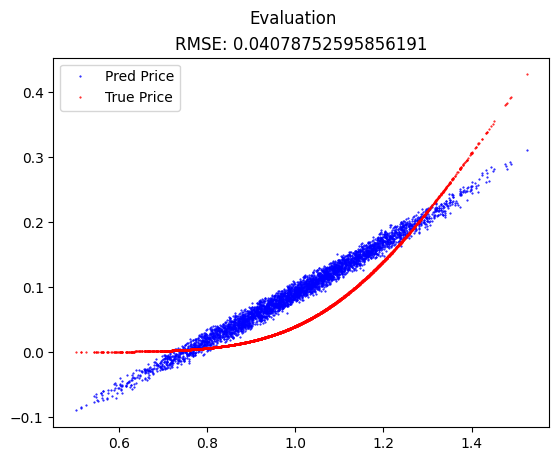

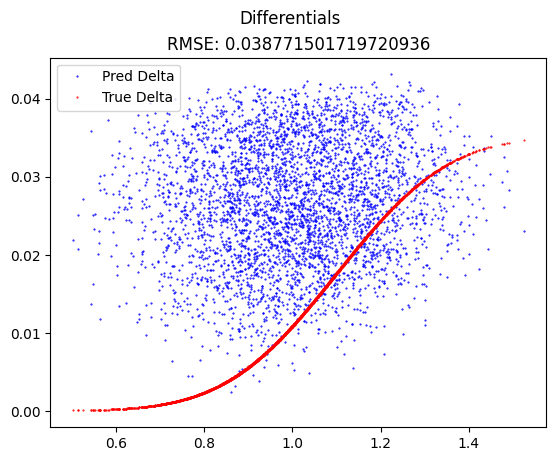

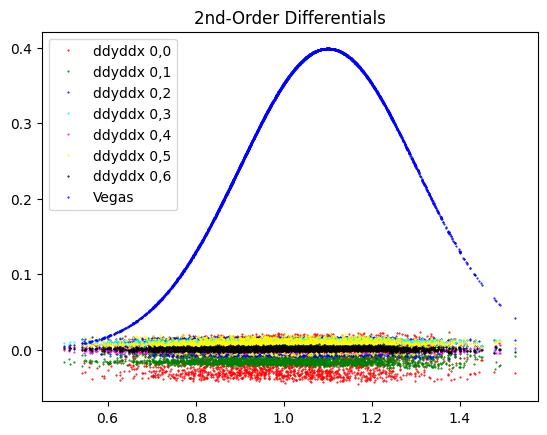

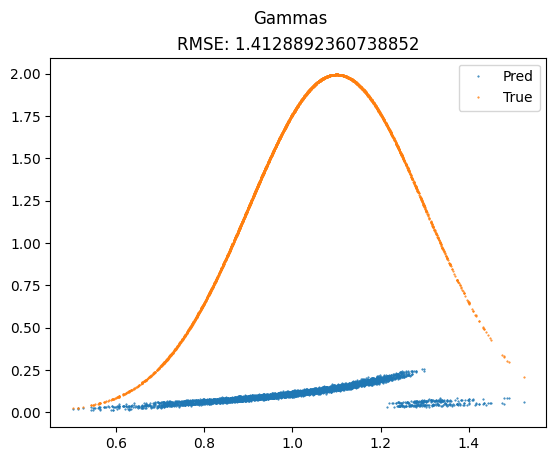

In [49]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

# Using smoothing of payoff function

In [17]:
def sigmoidal_smoothing(f, k):

    def smooth_f(*args):
        return 1/k * jnp.log(1 + jnp.exp(k * f(*args)))

    return smooth_f
        

In [18]:
smooth_f = sigmoidal_smoothing(jnp.maximum, 40)


In [19]:
jax.vmap(jax.grad(partial(smooth_f, 0.0)))(jnp.ones(shape=(7, )))

Array([1., 1., 1., 1., 1., 1., 1.], dtype=float64)

In [20]:
ys = smooth_f(0, x_train)



NameError: name 'x_train' is not defined

In [ ]:
plt.plot(x_train, ys, 'b.', markersize=1)

In [ ]:
ys = jax.vmap(jax.jacobian(partial(smooth_f, 0)))(x_train, 0)
plt.plot(x_train, ys, 'b.', markersize=1)

In [271]:
jax.jacobian(smooth_f)(0.0, x_train)

2023-06-26 16:52:47.472521: W external/xla/xla/service/hlo_rematerialization.cc:2218] Can't reduce memory use below 6.00GiB (6442352640 bytes) by rematerialization; only reduced to 12.25GiB (13153337344 bytes)
2023-06-26 16:52:57.511237: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 12.25GiB (rounded to 13153337344)requested by op 
2023-06-26 16:52:57.511419: W external/tsl/tsl/framework/bfc_allocator.cc:497] *___________________________________________________________________________________________________
2023-06-26 16:52:57.511452: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 13153337344 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:         0B
        maybe_live_out allocation:   12.25GiB
     preallocated temp allocat

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 13153337344 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         0B
              constant allocation:         0B
        maybe_live_out allocation:   12.25GiB
     preallocated temp allocation:         0B
                 total allocation:   12.25GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 12.25GiB
		Operator: op_name="jit(iota)/jit(main)/iota[dtype=int32 shape=(57344, 57344) dimension=0]" source_file="/tmp/ipykernel_40/264795555.py" source_line=1
		XLA Label: iota
		Shape: s32[57344,57344]
		==========================



In [262]:
partial(smooth_f, 0)(x_train[0])

Array([1.1794356 , 0.01805386, 1.2579072 , 0.89880556, 0.01732868,
       2.1022568 , 0.02913662], dtype=float32)

# Higher-Dimensional Example

In [48]:
bachelier_params = BachelierParams(n_dim=50, anti=False)
training_set = trainingSet(2*N_TRAINING_SAMPLES, bachelier_params, seed=SEED)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=2*N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.20000000298023224
S1.shape (array(16384, dtype=int32), array(50, dtype=int32))
vols is= [0.61903477 0.63260096 0.7175862  1.325458   0.33924034 2.101536
 1.628434   2.0628467  0.45057446 0.77220744 0.7985672  0.33054504
 2.17827    1.9404904  1.228216   1.8335282  0.26021242 1.2885274
 1.0143499  0.8307368  0.44611913 0.23053837 1.1668723  0.66634214
 2.0384452  1.1168482  0.7905702  1.3881769  1.8570516  1.0756079
 1.221835   1.6393164  1.335347   1.6871144  1.4327914  1.8159205
 1.7331254  2.1314173  1.4057491  0.6596275  0.6846957  1.4948864
 0.85417503 1.7456572  1.0269122  0.6041559  0.34143934 1.9060947
 0.8579867  0.26921645]
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True
Example values: 0.0, 0.0
W_fd_of_fd vs W_fd_of_vjp 0.00020081616821698844
MSE(Z_grad, Z_analytic) = 0.0
MSE(Z_vjp, Z_analytic) = 0.0
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True


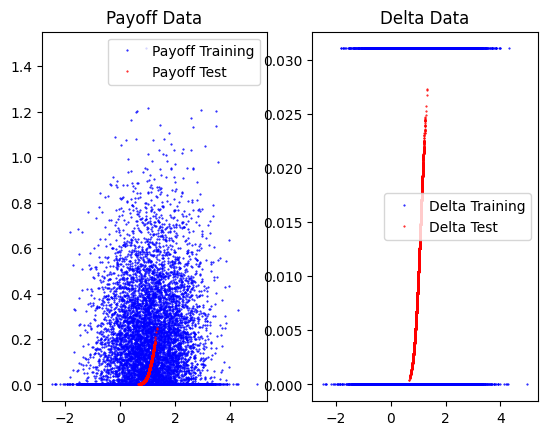

In [49]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

In [50]:
x_train, y_train, dydx_train = X, Y, Z

In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

## Standard ML

In [1084]:
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key)
# model = eqx.nn.MLP(key=subkey, in_size=x_train.shape[1], out_size=y_train.shape[1], width_size=20, depth=3, activation=jax.nn.elu)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

# use linear on-cycle decay scheduler
num_epochs = 100
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
# print(total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=1000., final_div_factor=1.0e4)


lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)

# lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
# lr_schedule = optax.constant_schedule(0.0001)
# lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)

# optim = optax.adam(learning_rate=0.001)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=lr_schedule)
# model = MakeScalar(model)
model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.03041  | Test Loss: 0.00334
Finished epoch   1  | Train Loss: 0.02049  | Test Loss: 0.00358
Finished epoch   2  | Train Loss: 0.02103  | Test Loss: 0.00361
Finished epoch   3  | Train Loss: 0.01721  | Test Loss: 0.00334
Finished epoch   4  | Train Loss: 0.01627  | Test Loss: 0.00292
Finished epoch   5  | Train Loss: 0.01414  | Test Loss: 0.00246
Finished epoch   6  | Train Loss: 0.01607  | Test Loss: 0.00213
Finished epoch   7  | Train Loss: 0.01404  | Test Loss: 0.00184
Finished epoch   8  | Train Loss: 0.01509  | Test Loss: 0.00152
Finished epoch   9  | Train Loss: 0.01506  | Test Loss: 0.00130
Finished epoch  10  | Train Loss: 0.01278  | Test Loss: 0.00115
Finished epoch  11  | Train Loss: 0.01379  | Test Loss: 0.00100
Finished epoch  12  | Train Loss: 0.01493  | Test Loss: 0.00091
Finished epoch  13  | Train Loss: 0.01180  | Test Loss: 0.00080
Finished epoch  14  | Train Loss: 0.01357  | Test Loss: 0.00072
Finished epoch  15  | Train Loss: 0.0142

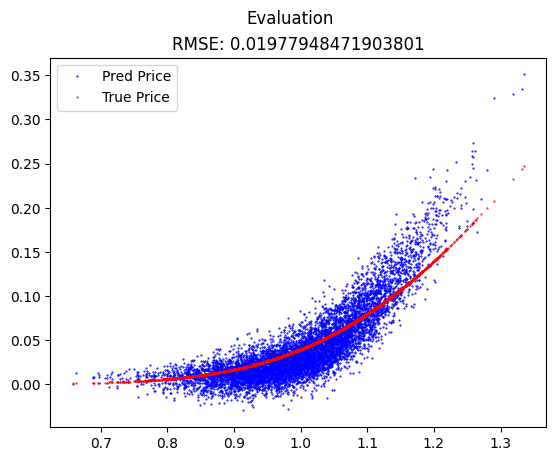

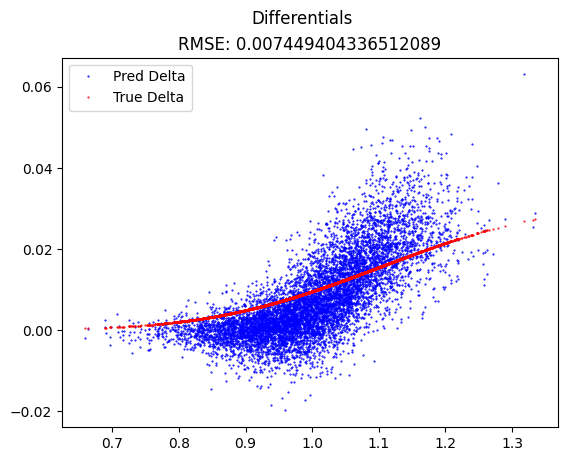

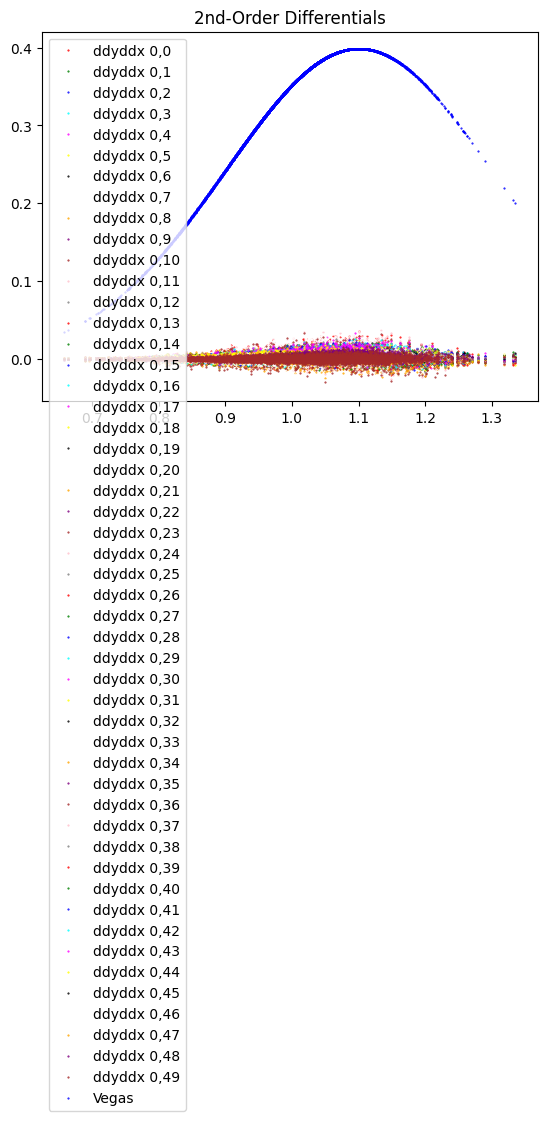

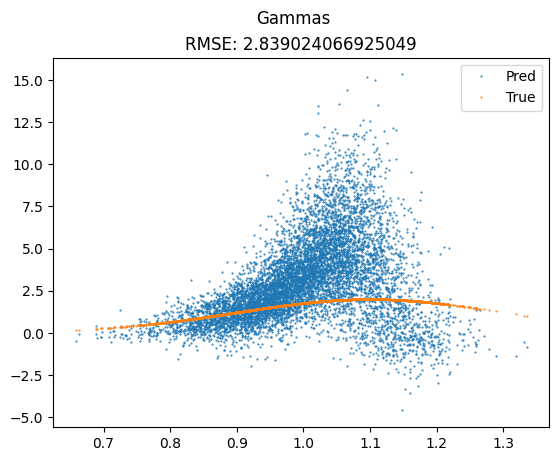

In [1085]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Differential ML

In [1086]:
seed = SEED
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

In [1087]:
total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
optim = optax.adam(learning_rate=lr_schedule)
model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)

Finished epoch   0  | Train Loss: 0.00042  | Test Loss: 0.05261
Finished epoch   1  | Train Loss: 0.00031  | Test Loss: 0.01905
Finished epoch   2  | Train Loss: 0.00034  | Test Loss: 0.00804
Finished epoch   3  | Train Loss: 0.00030  | Test Loss: 0.00710
Finished epoch   4  | Train Loss: 0.00031  | Test Loss: 0.00864
Finished epoch   5  | Train Loss: 0.00033  | Test Loss: 0.00877
Finished epoch   6  | Train Loss: 0.00029  | Test Loss: 0.00889
Finished epoch   7  | Train Loss: 0.00031  | Test Loss: 0.00892
Finished epoch   8  | Train Loss: 0.00031  | Test Loss: 0.01031
Finished epoch   9  | Train Loss: 0.00030  | Test Loss: 0.01180
Finished epoch  10  | Train Loss: 0.00029  | Test Loss: 0.01309
Finished epoch  11  | Train Loss: 0.00032  | Test Loss: 0.01034
Finished epoch  12  | Train Loss: 0.00029  | Test Loss: 0.01061
Finished epoch  13  | Train Loss: 0.00030  | Test Loss: 0.01154
Finished epoch  14  | Train Loss: 0.00029  | Test Loss: 0.01289
Finished epoch  15  | Train Loss: 0.0003

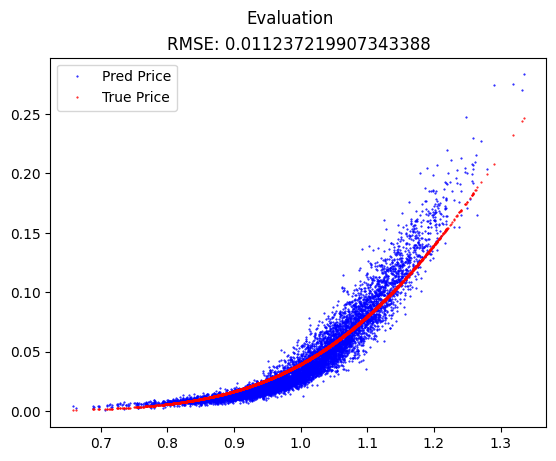

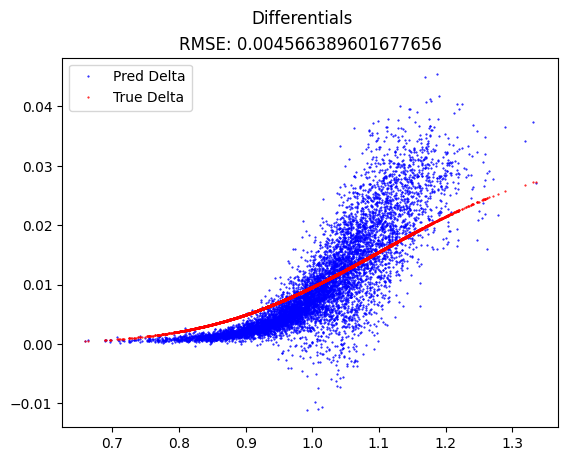

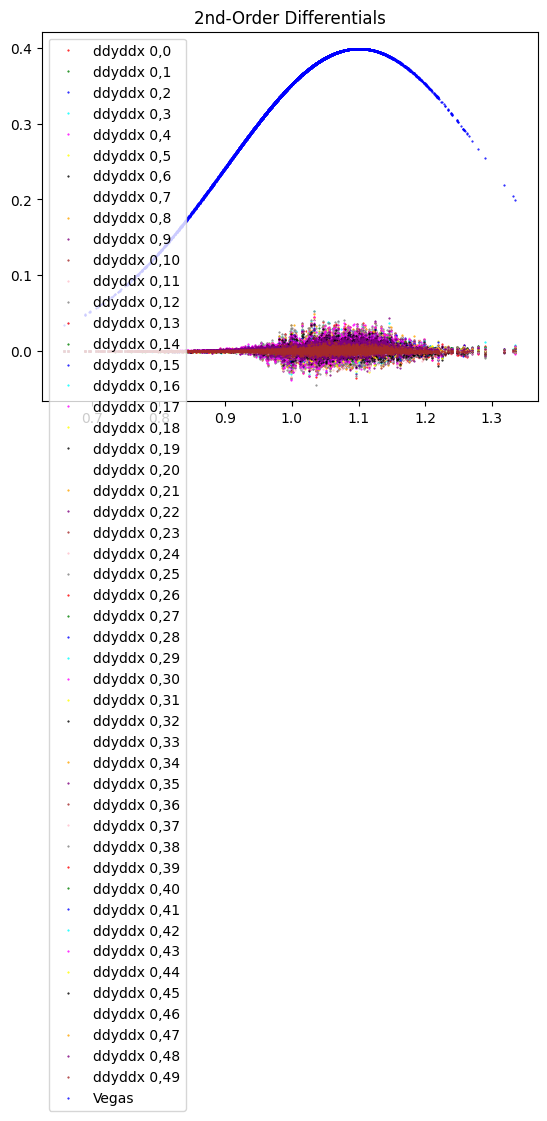

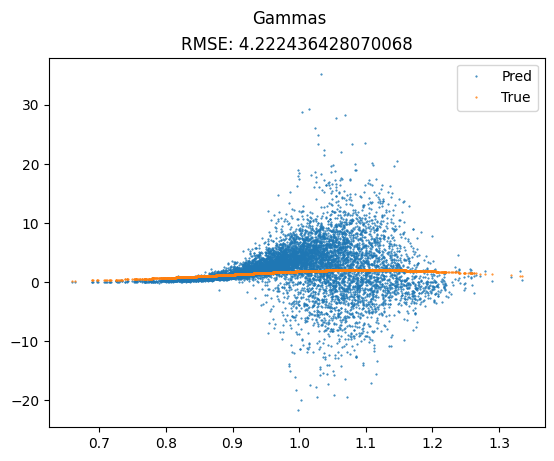

In [1088]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Second-Order Differential ML

In [1092]:
# NOTE: additional inc1 is needed to reconstruct the payoff for the second-order derivatives
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, inc1, y_train, dydx_train))

x_test = spots
y_test = prices
dydx_test = deltas
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

generator_train_ds = tfds.as_numpy(train_dataset)
generator_test_ds = tfds.as_numpy(test_dataset)

In [1094]:
key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x_train.shape[1], out_size=y_train.shape[1])

key, subkey = jax.random.split(key)
model = init_linear_weight(model, trunc_init, key)

num_epochs = NUM_EPOCHS

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# learning_rate=LEARNING_RATE
optim = optax.adam(learning_rate=lr_schedule)
model = dd_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs, debug=False)

Finished epoch   0  | Train Loss: 0.000150  | Test Loss: 0.036577
Finished epoch   1  | Train Loss: 0.000286  | Test Loss: 0.016427
Finished epoch   2  | Train Loss: 0.000302  | Test Loss: 0.010715
Finished epoch   3  | Train Loss: 0.000310  | Test Loss: 0.010410
Finished epoch   4  | Train Loss: 0.000295  | Test Loss: 0.009199
Finished epoch   5  | Train Loss: 0.000322  | Test Loss: 0.006172
Finished epoch   6  | Train Loss: 0.000323  | Test Loss: 0.006461
Finished epoch   7  | Train Loss: 0.000285  | Test Loss: 0.007872
Finished epoch   8  | Train Loss: 0.000323  | Test Loss: 0.005483
Finished epoch   9  | Train Loss: 0.000270  | Test Loss: 0.008124
Finished epoch  10  | Train Loss: 0.000283  | Test Loss: 0.006020
Finished epoch  11  | Train Loss: 0.000295  | Test Loss: 0.009214
Finished epoch  12  | Train Loss: 0.000273  | Test Loss: 0.011558
Finished epoch  13  | Train Loss: 0.000330  | Test Loss: 0.012765
Finished epoch  14  | Train Loss: 0.000276  | Test Loss: 0.007836
Finished e

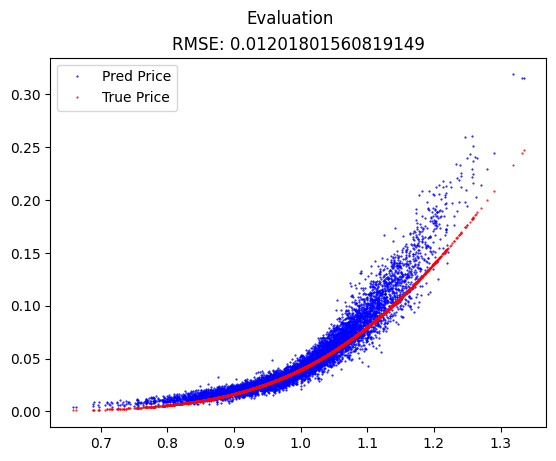

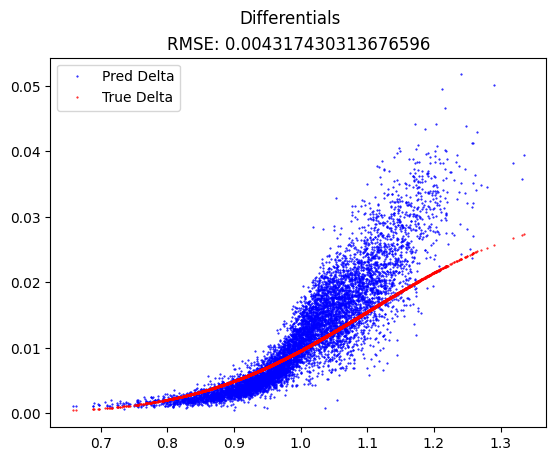

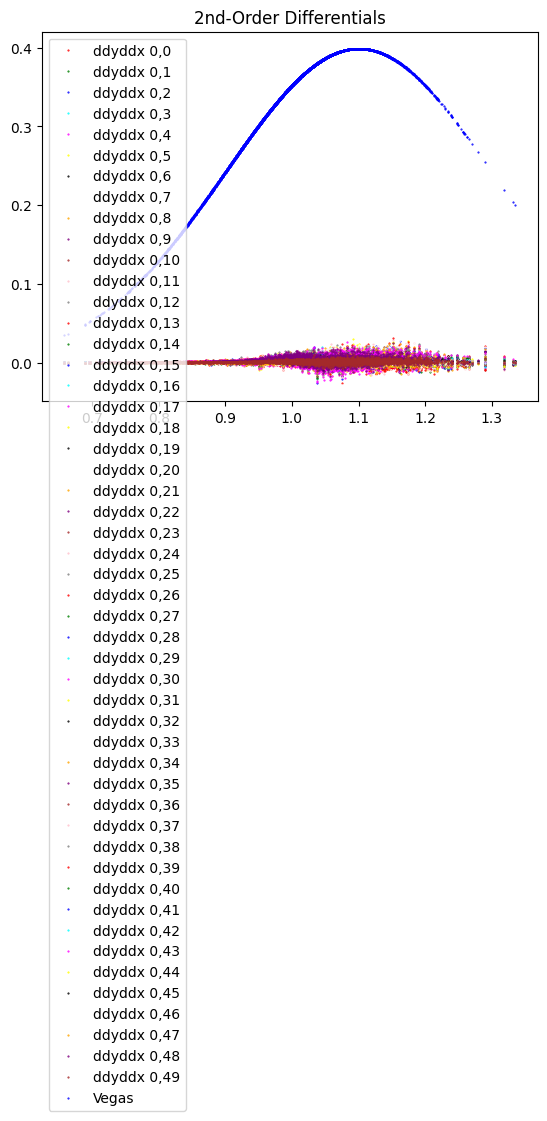

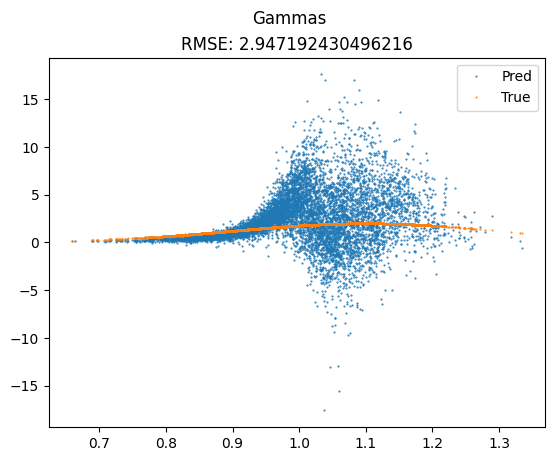

In [1095]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set)

## Experiment

In [703]:
def f(x):
  return x**2

xs = jnp.array([[3., 2., 1.]])
dys = jnp.array([[3., 2., 1.], 
                 [3., 2., 1.], 
                 [3., 2., 1.]])

pcs = jnp.array([[3., 2., 1.], 
                 [1., 1., 1.], 
                 [1., 2., 3.]])

print(xs.shape)
print(dys.shape)

print(xs @ dys)

print(pcs @ dys)
print(dys @ pcs)
# print(jnp.vdot(xs, dys))

hessian = jnp.tile(dys, (256, 1, 1))
print(hessian.shape)
print(pcs.shape)

# broadcasts the pcs accordingly
hvp = pcs @ hessian
print(hvp.shape)


(1, 3)
(3, 3)
[[18. 12.  6.]]
[[18. 12.  6.]
 [ 9.  6.  3.]
 [18. 12.  6.]]
[[12. 10.  8.]
 [12. 10.  8.]
 [12. 10.  8.]]
(256, 3, 3)
(3, 3)
(256, 3, 3)


In [704]:
def f(x):
  return x**2

xs = jnp.array([3.0, 2.0, 1.0])

dys = vmap(grad(f))(xs)
print(dys)
print(dys.shape)
# only now we know the vectors
# vs = 

# jnp.vdot(dys, jnp.ones_like(dys))

vmap(jax.hessian(f))(xs)
jax.hessian(f)(xs)

[6. 4. 2.]
(3,)


Array([[[2., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 2., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 2.]]], dtype=float32)

In [54]:
def f(x):
  return x**2

xs = jnp.array([3.0, 2.0, 1.0])

y, vjp_fn = jax.vjp(f, xs)
print(y)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

dy_vjp, vjpvjp_fn = jax.vjp(vjp_fn, jnp.ones_like(y))
print(dy_vjp)

# ddy = vjpvjp_fn(jnp.ones_like(dy_vjp))
# ddy = vjpvjp_fn((jnp.ones_like(dy_vjp[0]),))
# print(ddy)

# hvp(f, xs, xs)

hess = jax.hessian(f)
print(vmap(hess)(xs))


[9. 4. 1.]
(Array([6., 4., 2.], dtype=float32),)
(Array([6., 4., 2.], dtype=float32),)
[2. 2. 2.]


In [55]:
def f(x):
    return x**2

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 3))
print(x)

y, vjp_fn = jax.vjp(f, x)
print(y)

cotanget = (jnp.ones_like(y[0]), )
dy = vjp_fn(cotanget)
print(len(dy))
cotanget = (jnp.ones_like(dy[0]), )

dy_, vjpvjp_fn = jax.vjp(vjp_fn, cotangent)
if 0:
    print(dy)
    print(dy_)
    dy_ = dy_[0]
    # print(vmap(vjpvjp_fn)((jnp.ones_like(dy_), )))
    print(vjpvjp_fn((jnp.ones_like(dy_), )))

    print(jax.jacobian(f)(x))
    print(jax.hessian(f)(x))


[[-0.38812608 -0.04487164 -2.0427258 ]
 [ 0.07932311 -0.04617044  0.7959976 ]
 [-1.4411978  -1.6929979  -0.37369204]]
[[1.5064184e-01 2.0134645e-03 4.1727285e+00]
 [6.2921550e-03 2.1317096e-03 6.3361222e-01]
 [2.0770509e+00 2.8662419e+00 1.3964574e-01]]


TypeError: Tree structure of cotangent input PyTreeDef((*,)), does not match structure of primal output PyTreeDef(*).

In [ ]:
# with eqx

def f(x):
    return x**2

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 3))
print(x)

y, vjp_fn = eqx.filter_vjp(f, x)
print(y)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, jnp.ones_like(y))
print(dy)

[[-0.38812608 -0.04487164 -2.0427258 ]
 [ 0.07932311 -0.04617044  0.7959976 ]
 [-1.4411978  -1.6929979  -0.37369204]]
[[1.5064184e-01 2.0134645e-03 4.1727285e+00]
 [6.2921550e-03 2.1317096e-03 6.3361222e-01]
 [2.0770509e+00 2.8662419e+00 1.3964574e-01]]
(Array([[-0.77625215, -0.08974329, -4.0854516 ],
       [ 0.15864621, -0.09234088,  1.5919952 ],
       [-2.8823955 , -3.3859959 , -0.7473841 ]], dtype=float32),)
(Array([[-0.77625215, -0.08974329, -4.0854516 ],
       [ 0.15864621, -0.09234088,  1.5919952 ],
       [-2.8823955 , -3.3859959 , -0.7473841 ]], dtype=float32),)


In [ ]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7,))
# print(x.shape)
y_ = MakeScalar(model)(x)

jac = jax.jacobian(model)(x)
hess = jax.hessian(model)(x)
# y, vjp_fn = eqx.filter_vjp(MakeScalar(model), x)
# print("y", y)

y, J, vjp_fn = value_and_jacrev(model, x)

# print(y.size)

def hvp(f, v):
    dy, vjpvjp_fn = eqx.filter_vjp(f, v)
    dy = dy[0]
    basis = jnp.eye(dy.size, dtype=dy.dtype)
    H = vmap(vjpvjp_fn)((basis,))
    return dy, H

# dy, H = hvp(vjp_fn, jnp.ones_like(y))
# print("dy", dy)
dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, jnp.ones_like(y))
dy0 = dy[0]
basis = jnp.eye(dy0.size, dtype=dy0.dtype) # same as jnp.eye(x.size, dtype=x.dtype)

def vjpvjp_el(v):
    return vjpvjp_fn((v,)) 

# ddy = vjpvjp_fn((basis[0],))
ddy = vjpvjp_fn((jnp.ones_like(dy0),))
print("dy", dy)
print("ddy", ddy)

H = vmap(vjpvjp_el)(basis)

def hvp(f, primals, tangents):
    return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

def hmp(f, primals):

    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

hvp_res = hvp(MakeScalar(model), (x,), (basis[0],))
print("hvp: ", hvp_res)

hmp_fn = hmp(MakeScalar(model), x)
hvp_res = hmp_fn(basis)
print("hmp: ", hvp_res)

print(y_)
print(y)

print(jac)
print(J)

print(hess)
print(H)

dy (Array([-0.00836775, -0.00073751, -0.00439059, -0.00280592, -0.00235696,
       -0.0056589 , -0.00504256], dtype=float32),)
ddy (Array([-0.02936021], dtype=float32),)
hvp:  [-6.1080320e-04 -2.3331182e-04 -9.3602127e-04 -3.3858477e-04
 -8.6907647e-04 -9.5272699e-06 -1.3695123e-04]
hmp:  [[-6.1080308e-04 -2.3331185e-04 -9.3602127e-04 -3.3858477e-04
  -8.6907664e-04 -9.5272335e-06 -1.3695104e-04]
 [-2.3331189e-04  1.7222749e-04 -3.7502850e-04 -1.7532007e-05
  -5.3374610e-05 -1.4621431e-05 -7.0111157e-04]
 [-9.3602150e-04 -3.7502850e-04 -8.4217149e-04  7.5299118e-04
   5.8836385e-04  4.5638336e-04 -1.5317803e-03]
 [-3.3858471e-04 -1.7531909e-05  7.5299095e-04  7.7574287e-04
   3.8701249e-04 -1.7244610e-04 -6.1574130e-04]
 [-8.6907647e-04 -5.3374501e-05  5.8836397e-04  3.8701255e-04
  -1.8838544e-04 -4.7550054e-04 -5.6692900e-04]
 [-9.5272526e-06 -1.4621274e-05  4.5638336e-04 -1.7244593e-04
  -4.7550065e-04 -4.1496183e-04  1.8320826e-04]
 [-1.3695117e-04 -7.0111186e-04 -1.5317801e-03 -6.

In [ ]:
# now same as above but with a batch of vector data
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (3, 7))
y_ = vmap(MakeScalar(model))(x)

print(x)
print(y_)

jac = vmap(jax.jacobian(model))(x)
hess = eqx.filter_jit(vmap(jax.hessian(model)))(x)

jac_ = vmap(jax.grad(MakeScalar(model)))(x)

def hvp(f, primals, tangents):
    return eqx.filter_jvp(eqx.filter_grad(f), primals, tangents)[1]

def hmp(f, primals):
    
    def hvp_(tangents):
        return hvp(f, (primals,), (tangents, ))

    return eqx.filter_vmap(hvp_)

def batch_hmp(f):

    def hvp_(primals, tangents):
        return hvp(f, (primals,), (tangents,))

    # return eqx.filter_jit(eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1)))
    return eqx.filter_jit(eqx.filter_vmap(eqx.filter_vmap(hvp_, in_axes=(0, None)), in_axes=(None, 1)))


# def batch_hmp_pca(f):

#     def hvp_(primals, tangents):
#         return hvp(f, (primals,), (tangents,))

#     fn = eqx.filter_vmap(hvp_, in_axes=(0, None))
#     jax.lax.cond(pred, lambda x: x, lambda x: jnp.zeros_like(x), x)

#     return eqx.filter_jit(eqx.filter_vmap(, in_axes=(None, 1)))


basis = jnp.eye(x.shape[-1], dtype=x.dtype)
print(basis.shape)
hvp_res = hvp(MakeScalar(model), (x[0],), (basis[0],))


hmp_fn = hmp(MakeScalar(model), x[0])
hvp_res = hmp_fn(basis)

batch_hmp_fn = eqx.filter_jit(batch_hmp(MakeScalar(model)))
batch_hmp_res = batch_hmp_fn(x, basis)
batch_hmp_res = jnp.transpose(batch_hmp_res, (1, 0, 2))
print("batch_hmp_res", batch_hmp_res)

hess_vs_hmp = jnp.allclose(hess[:, 0, :, :], batch_hmp_res)
print("hmp close to hess: ", hess_vs_hmp)


@eqx.filter_jit
def dynamic_slices_do_not_work():
    k = jnp.asarray(jnp.sum(basis), dtype=jnp.int32) - 5
    print('k', k)

    batch_hmp_selected = eqx.filter_jit(batch_hmp_fn)(x, basis[:, :k])
    batch_hmp_selected = jnp.transpose(batch_hmp_selected, (1, 0, 2))
    print("bath_hmp_selected", batch_hmp_selected.shape)
    print("bath_hmp_selected", batch_hmp_selected)

# the following does not work in jax
# dynamic_slices_do_not_work()

# have to avoid jit to make it work
batch_hmp_selected = eqx.filter_jit(batch_hmp_fn)(x, basis[:, :2])
batch_hmp_selected = jnp.transpose(batch_hmp_selected, (1, 0, 2))
print("bath_hmp_selected", batch_hmp_selected.shape)
print("bath_hmp_selected", batch_hmp_selected)

# the following does work in jax
# we first set the tangents we do not want to compute to zero
# such that we internally skip those computations. Whether this is
# faster than computing everything and then selecting the relevant
# parts is unclear.
batch_hmp_fn_select = eqx.filter_jit(batch_hmp_select(MakeScalar(model)))

# mask the basis to only compute the first 5 tangents
# basis_mask = jnp.asarray(jnp.sum(basis), dtype=jnp.int32) - 5
# basis_mask = jnp.concatenate([jnp.ones(basis_mask), jnp.zeros(basis.size - basis_mask)])
# basis_mask = jnp.reshape(basis_mask, basis.shape)

# in numpy zero out the next n columns of basis
basis_masked = basis.at[:, 2:].set(0.)
batch_hmp_res = batch_hmp_fn_select(x, basis_masked)
batch_hmp_res = jnp.transpose(batch_hmp_res, (1, 0, 2))
print("batch_hmp_pca_res", batch_hmp_res)

print("jac from grad shape", jac_.shape)
print("jac from grad: ", jac_)
print("jacobian.shape", jac.shape)
print("jacobian", jac)
print("hessian.shape", hess.shape)
print("hessian", hess)

[[-1.0110744   0.8579503  -1.408211    0.30537882 -0.5529018  -0.20745467
  -0.91298896]
 [ 0.8951212  -1.7360477   0.47285226 -1.2633834   0.03138541  1.3681892
  -0.83616734]
 [-0.6514678   1.1204553  -2.0303192   0.5996085  -0.8729886   0.93188107
  -0.01794553]]
[0.03812329 0.00545319 0.02495258]
(7, 7)
batch_hmp_res [[[-3.3906644e-04 -7.7072233e-05 -7.4307172e-04 -7.3547720e-04
   -1.3029812e-03 -1.6769826e-04  7.4271910e-04]
  [-7.7072327e-05  7.7760153e-05 -2.1127101e-04  1.9880421e-05
   -2.7794237e-04 -2.2684189e-05 -3.4409881e-04]
  [-7.4307207e-04 -2.1127108e-04 -3.3174560e-04  5.8598543e-04
    2.5427618e-04  2.0159592e-04 -1.1795548e-03]
  [-7.3547708e-04  1.9880550e-05  5.8598537e-04  8.7144633e-04
    5.7646551e-04 -2.2871024e-04 -1.4743009e-03]
  [-1.3029811e-03 -2.7794242e-04  2.5427606e-04  5.7646557e-04
    1.0763346e-04 -3.4260331e-04 -1.2564788e-03]
  [-1.6769831e-04 -2.2684231e-05  2.0159601e-04 -2.2871017e-04
   -3.4260339e-04 -4.7583476e-04 -2.2669775e-04]
  [ 7

In [ ]:
# (small) benchmark 
# we observe that doing a select is slower than computing everything

key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (8 * 1024, 100))
y = jax.random.normal(subkey, (8 * 1024, 1))
basis = jnp.eye(x.shape[-1], dtype=x.dtype)

key, subkey = jax.random.split(key)
model = MLP_Normalized(key, in_size=x.shape[1], out_size=y.shape[1])

batch_hmp_fn = eqx.filter_jit(batch_hmp(MakeScalar(model)))
batch_hmp_fn_select = eqx.filter_jit(batch_hmp_select(MakeScalar(model)))
%timeit batch_hmp_fn_select(x, basis) 
%timeit batch_hmp_fn(x, basis) 

basis_masked = basis.at[:, 2:].set(0.)

%timeit batch_hmp_fn_select(x, basis_masked) 
%timeit batch_hmp_fn(x, basis_masked) 



408 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
296 µs ± 41.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.9 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.9 ms ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:

res_select = batch_hmp_fn_select(x, basis) 
res_normal = batch_hmp_fn(x, basis) 

print(res_select.shape)
# print(res_normal)
# print(jnp.sum(res_select - res_normal))

NameError: name 'batch_hmp_fn_select' is not defined

In [57]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7,))
# print(x.shape)
y_ = MakeScalar(model)(x)
# print(y_)

y, vjp_fn = eqx.filter_vjp(MakeScalar(model), x)
print("y", y)

cotangent = jnp.ones_like(y)
dy, vjpvjp_fn = eqx.filter_vjp(vjp_fn, cotangent)
print("dy", dy)
print(vjp_fn(cotangent))

# ddy = vjpvjp_fn((jnp.ones_like(dy[0]),))
ddy = vjpvjp_fn(dy)
print("ddy", ddy)
print("x", x)

print(jax.hessian(model)(x))
print(jax.hessian(MakeScalar(model))(x))

# print(jax.vmap(jax.grad)(jax.grad(MakeScalar(model)))(x))

# eqx.filter_vmap(eqx.filter_grad)(eqx.filter_grad(MakeScalar(model)))(x)

if 0:
    y, vjp_fn = eqx.filter_vmap(partial(eqx.filter_vjp, MakeScalar(model)))(x)
    print(y)
    print(y.shape)
    # dy = eqx.filter_vmap(vjp_fn)(jnp.ones_like(x))
    # dy = vjp_fn((jnp.array([1.0]),))

    cotangent = jnp.ones(shape=())
    vjp_fn(cotangent)

y -0.013149001
dy (Array([ 0.00407964,  0.00996458,  0.00045701,  0.00246731,  0.01029229,
        0.00188987, -0.00032944], dtype=float32),)
(Array([ 0.00407964,  0.00996458,  0.00045701,  0.00246731,  0.01029229,
        0.00188987, -0.00032944], dtype=float32),)
ddy (Array(0.00023184, dtype=float32),)
x [-1.4986218  -0.05708544  0.09740688 -0.0673765  -0.90798175  0.17307237
  0.39909264]
[[[ 3.7015339e-03 -9.5647189e-04  3.4639451e-03  1.5701923e-04
   -1.6476470e-03  2.0245179e-03  1.9244381e-03]
  [-9.5647160e-04  2.5739521e-03 -3.9923601e-03 -1.6734296e-03
    3.5150332e-04 -1.7534450e-03 -2.5777954e-03]
  [ 3.4639449e-03 -3.9923610e-03  2.5150692e-03 -2.5630192e-04
   -3.4998145e-03  5.0159247e-04  1.6032613e-03]
  [ 1.5701915e-04 -1.6734299e-03 -2.5630163e-04 -1.4354529e-04
   -1.1739540e-03 -4.9362372e-04  2.0765999e-04]
  [-1.6476471e-03  3.5150276e-04 -3.4998143e-03 -1.1739542e-03
    1.0754332e-03 -1.7362719e-03 -1.9456412e-03]
  [ 2.0245172e-03 -1.7534447e-03  5.0159270e-

In [58]:
key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (7, 7))
# print(x.shape)
y_ = vmap(MakeScalar(model))(x)
# print(y_)

y, vjp_fn = eqx.filter_vmap(partial(eqx.filter_vjp, MakeScalar(model)))(x)
print(y)
print(y.shape)
# dy = eqx.filter_vmap(vjp_fn)(jnp.ones_like(x))
# dy = vjp_fn((jnp.array([1.0]),))

cotangent = jnp.ones(shape=())
vjp_fn(cotangent)

[-0.00530234  0.0136837   0.01398236 -0.00030544 -0.00558965 -0.03030739
 -0.00791175]
(7,)


TypeError: dot_general requires lhs dimension numbers to be nonnegative and less than the number of axes of the lhs value, got lhs_batch of () and lhs_contracting of (0, 1) for lhs of rank 1

In [ ]:
# experiment with using finite differences over vjp

def f(x):
  return 2 * x**3

xs = jnp.array([1.0, 2.0])
y, vjp_fn = jax.vjp(f, xs)
print(y)

cotangent = jnp.ones_like(y)
print(cotangent)
dy, vjpvjp_fn = jax.vjp(vjp_fn, cotangent)
print(dy)

# using ad
ddy = vjpvjp_fn((jnp.ones_like(y), ))
print(ddy)

# now using fd, NOTE: I don't actually need vjpvjp here
h = 1e-3

fd_xph = f(xs + jnp.array([h, h]))
fd_xmh = f(xs - jnp.array([h, h]))
fd = (fd_xph - fd_xmh) / (2 * h)
print("FD of f(x)")
print(fd)


fdd_xph, = vjp_fn(cotangent + jnp.array([h, h]))
fdd_xmh, = vjp_fn(cotangent - jnp.array([h, h]))

print(fdd_xph)
print(fdd_xmh)
fdd = (fdd_xph - fdd_xmh) / (2 * h)

print("FD over vjp of f(x)")
print(fdd)

grad_f = grad(f)

fdd_xph = vmap(grad_f)(xs + h)
fdd_xmh = vmap(grad_f)(xs - h)
fdd = (fdd_xph - fdd_xmh) / (2 * h)
print("FD over grad of f(x)")
print(fdd)

jax.hessian(f)(xs)

[ 2. 16.]
[1. 1.]
(Array([ 6., 24.], dtype=float32),)
(Array([ 6., 24.], dtype=float32),)
FD of f(x)
[ 6.0000415 23.99969  ]
[ 6.0060005 24.024002 ]
[ 5.994 23.976]
FD over vjp of f(x)
[ 6.00028 24.00112]
FD over grad of f(x)
[12.000083 23.999212]


Array([[[12.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0., 24.]]], dtype=float32)

In [ ]:
def f(x):
    return x**2

partial_vjp = partial(jax.vjp, f)

# xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = partial_vjp(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])

print(vjp_fn)

dy = vjp_fn(jnp.ones_like(y))
print(dy)

[3. 2. 1.]
[9. 4. 1.]
()
9.0
Partial(_HashableCallableShim(functools.partial(<function _vjp_pullback_wrapper at 0x7ff45e4895a0>, 'f', [dtype('float32')], [(3,)], (PyTreeDef(*), PyTreeDef((*,))))), Partial(_HashableCallableShim(functools.partial(<function vjp.<locals>.unbound_vjp at 0x7ff0964c8040>, [(ShapedArray(float32[3]), None)], { lambda a:f32[3]; b:f32[3]. let c:f32[3] = mul b a in (c,) })), (Array([6., 4., 2.], dtype=float32),)))
(Array([6., 4., 2.], dtype=float32),)


In [ ]:

def inner_fn(x):
    return x ** 3

def outer_fn(x):
    # def inner(x, y):
        # return inner_fn(x, y)
    
    _, vjp_inner = jax.vjp(inner_fn, x)
    cotangent = jnp.ones_like(x)
    grad_inner_x, = vjp_inner(x)
    return grad_inner_x

# Example usage
# x = jnp.array([2.0, 1.0])
x = jnp.array(1.0)
y = jnp.array(3.0)

grad_inner_x, vjp_outer = jax.vjp(outer_fn, x)
grad_outer_x = vjp_outer(1.0)

print(f"Gradient of inner_fn with respect to x: {grad_inner_x}")
print(f"Gradient of outer_fn with respect to x: {grad_outer_x}")
# print(f"Gradient of outer_fn with respect to y: {grad_outer_y}")

Gradient of inner_fn with respect to x: 3.0
Gradient of outer_fn with respect to x: (Array(9., dtype=float32, weak_type=True),)


In [ ]:
def f(x):
    return x**2

partial_vjp = partial(jax.vjp, f)

xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
# xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = eqx.filter_vmap(partial_vjp)(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])

print(vjp_fn)


# this is an internal problem of the generated vjp_fn since 
# it probably gets confused with the vmap
# print(vjp_fn(jnp.ones_like(y[0])))

# but the below also doesn't work
# print(vjp_fn(jnp.ones_like(y)))

# print(vmap(vjp_fn)(jnp.ones(shape=(3,3))))


[[3. 2. 1.]
 [6. 5. 4.]
 [9. 8. 7.]]
[[ 9.  4.  1.]
 [36. 25. 16.]
 [81. 64. 49.]]
(3,)
[9. 4. 1.]
Partial(_HashableCallableShim(functools.partial(<function _vjp_pullback_wrapper at 0x7ff45e4895a0>, 'f', [dtype('float32')], [(3,)], (PyTreeDef(*), PyTreeDef((*,))))), Partial(_HashableCallableShim(functools.partial(<function vjp.<locals>.unbound_vjp at 0x7ff210469fc0>, [(ShapedArray(float32[3]), None)], { lambda a:f32[3]; b:f32[3]. let c:f32[3] = mul b a in (c,) })), (Array([[ 6.,  4.,  2.],
       [12., 10.,  8.],
       [18., 16., 14.]], dtype=float32),)))


In [ ]:
def f(x):
    return x**2

# maybe first vmap the vjp?
# partial_vjp = partial(jax.vjp, f)
vmap_vjp = vmap(lambda x: jax.vjp(f, x))

xs = jnp.array([[3.0, 2.0, 1.0], [6.0, 5.0, 4.0], [9., 8., 7.]])
# xs = jnp.array([3.0, 2.0, 1.0])
# xs = jnp.tile(xs, (5, 1))

# xs = jax.random.normal(key, shape=(256, 7))
print(xs)
# xs = jnp.array(1.0)

y, vjp_fn = vmap_vjp(xs)
# y, vjp_fn = partial_vjp(xs)
print(y)

print(y[0].shape)
print(y[0])


#print(vjp_fn(jnp.ones_like(y)))


[[3. 2. 1.]
 [6. 5. 4.]
 [9. 8. 7.]]
[[ 9.  4.  1.]
 [36. 25. 16.]
 [81. 64. 49.]]
(3,)
[9. 4. 1.]
